In [1]:
#IMPORTING LIBRARIES

import scipy.special as sp # UNUSED?
import numpy as np # NumPy offers comprehensive mathematical functions, random number generators, linear algebra routines, Fourier transforms, and more
import matplotlib.pyplot as plt # Provides a MATLAB-like way of plotting
import pandas as pd # Data analysis and manipulation tool. Used to read in bathymetry data (M77T file), Directions data (excel file), and organises Vmean into a labelled data structure
# M77T data files are created from raw data collected by marine researchers using InfoBank
from scipy.interpolate import CubicSpline as SP # Used to create a spline about the velocity, shape parameter and proability data
from scipy.optimize import minimize,least_squares,Bounds,basinhopping # Optimizing and route finding
from scipy.special import gamma # Gamma function used for weibull distribution
import matplotlib.cm as cm # UNUSED?
from Boruvka_Mod import Graph # imports class graph from Boruvka_Mod python file
import utm # Used to help convert latitude and longitude in bathymetry data to centred eastings and northings
import scipy.interpolate as spline # Used to smooth the bathymetry data
from matplotlib.colors import ListedColormap # UNUSED?
import math # Provides access to the mathematical functions
from time import perf_counter # Returns the float value of time in seconds. Used to record run time for clustering and optimization algorithms
from minmax_kmeans import minsize_kmeans # imports minsize_kmeans function from minmax_kmeans python file
import pulp #Used in the clustering algorithm to generate MPS and LP files
import scipy.signal as signal 
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline, BSpline
from scipy.spatial import ConvexHull

In [2]:
# KEY PARAMETERS USED THROUGHOUT MODEL

a = 350 # minimum distances turbines can be from one another in m.
b = 3000 # distance that turbines have negligible affect on eachother in m. If model changes this value could change

maximumturbinespertree = 10 # number of turbines allowed along a single cable from the substation.
budget = np.float64(300000000) # Budget in £ to build the wind farm, accounting for construction costs.
DistanceToShore = 15000 # m #distance of the wind farm from shore
TooCloseShore = 5000 # m # minimum distance the wind farm must be from shore
xCoordOnshoreSub = 0 # x coordinate of the onshore substation (y coordinate is -(DistanceToShore))

USDtoGBP = 1/1.351  
EURtoGBP = 1/1.19

IACableCostperMeter = 409.2*EURtoGBP
ExportCableCostperMeter = 833.625*EURtoGBP

CostperTurbineUSD = np.float64(3000000) # USD
CostperTurbine = CostperTurbineUSD*USDtoGBP # GBP

OperatingandMaintenanceCostsperAnnum = np.float64(65500) # GBP
LifeTimeTurbineOperatingTime = 20 # years 120000 # hours
MaintenanceCostperTurbine = OperatingandMaintenanceCostsperAnnum*LifeTimeTurbineOperatingTime # in GBP

LandCostperHectare = 17245 # in GBP
LandCostpermSquared = LandCostperHectare/10000 #  in GBP

OffshoreSubstationCostperMW = np.float64(104000*EURtoGBP)
OnshoreSubstationCostperMW = np.float64(87250*EURtoGBP)
# Costs  associated with the purchase and installation of electrical substations as well as the buildings required for housing the staff and additional equipment required for the running of the wind farm.

ElectricityCostperkWh = 0.144 # 14.4 pence - £0.144
DiscountRate = 0.07 # 7%

TurbineRating = 2 #2MW

GravityBase = 409000*EURtoGBP*TurbineRating #409000euro/MW
Monopile = 551000*EURtoGBP*TurbineRating
Jacket = 665000*EURtoGBP*TurbineRating
TensionLeg = 1163000*EURtoGBP*TurbineRating

In [3]:
#READING IN BATHYMETRY DATA
data = pd.read_csv("nsea86.m77t", sep='\t') # Reads in all data from file including depth data, lattitude, longitude etc.
mindepth = min(data['CORR_DEPTH']) # Retrieves minimum depth value from data file 'nsea86.m77t'    
print('Shallowest depth:', mindepth, 'm') #Prints out the result for the smallest depth value

Shallowest depth: 17.2 m


In [4]:
###CALCULATES THE INITIAL NUMBER OF TURBINES THE OPTIMISATION SHOULD START WITH.    
maxnodespertree = maximumturbinespertree # As above
minareaperturbine = (1/2)*(math.sqrt(3))*(a**2) # Area per turbine assuming 350m between each turbine
LandCostperTurbine=minareaperturbine*(LandCostpermSquared) # Cost with minimum area
MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(mindepth)**2) - 0.0002*(float(mindepth)) + 0.9459)-CostperTurbine # Uses shallowest depth from before
print('Min depth cost per turbine = £',MinDepthCostPerTurbine) # prints result
MinIACableCostPerTurbine = a*IACableCostperMeter
MinExportCableCost = TooCloseShore*ExportCableCostperMeter # minimum export cable cost with respect to the minimum distance the wind farm must be form shore
MinFoundationCostPerTurbine = GravityBase*TurbineRating

MinCostperTurbTot = CostperTurbine+LandCostperTurbine+MaintenanceCostperTurbine+MinDepthCostPerTurbine+MinIACableCostPerTurbine+MinFoundationCostPerTurbine # Total costs (excluding export cable and fixed costs)
nnturb = (budget-MinExportCableCost)/MinCostperTurbTot 
FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*nnturb*TurbineRating # *2 due to 2MW turbines being used *0.4 for assuming 40% effciency
nturb = (budget-FixedCost-MinExportCableCost)/(MinCostperTurbTot) # Turbines possible with current budget
nturb = math.floor(nturb) # rounds down as cannot have fraction of a turbine
minarea = minareaperturbine*nturb # Overall minimum area considering the amount of turbines
maxarea = nturb*(1/2)*(math.sqrt(3))*(b**2) # Careful this isn't bigger than the entire size of the scaled nsea86 sea floor.

print('Min area per turbine =', minareaperturbine, 'm^2') # prints results
print('Min area =', minarea, 'm^2')
print('Max number of turbines =', nturb)
print('Max area =', maxarea, 'm^2')

Min depth cost per turbine = £ 3615.099925980903
Min area per turbine = 106088.11196359372 m^2
Min area = 5622669.934070467 m^2
Max number of turbines = 53
Max area = 413094117.6051772 m^2


In [5]:
#PRE-OPTIMISATION TURBINE POSITIONING

# places substation at (0,0).
# places 1st turbine at vector (a,0) from substation. a=350m from before
# places 2nd turbine at vector (0.5a,0.5aroot3) from prev. 
# places 3rd turbine at vector (-a,0) from prev
# places 4th turbine at vector (-0.5a,-0.5aroot3) from prev, continues in this spiralling fashion

positionlist = np.empty((nturb+1,2)) # Creates an empty list of size (number of turbines + 1 (since 0 position is substation),2)
turbineposition = np.array([[0,0]]) # Creates [0,0] array for introducing [x,y] coordinates for each turbine
positionlist[0,:] = turbineposition # 

oddcounter = 0
evencounter = 0
i = 0
k = 0

while k<nturb+1: # Loops for number of turbines 
    i += 1
    if (i%2)!= 0: # i is odd
        oddcounter+=1
        for j in range(oddcounter):
            k += 1
            if k == nturb+1:
                break
            if (oddcounter%2)!= 0: #oddcounter is odd
                shift = np.array([[a, 0]])
            else:
                shift = np.array([[-a, 0]])
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
        
    else:
        evencounter+=1
        for j in range(evencounter):
            k += 1
            if k == nturb+1:
                break
            if (evencounter%2)!= 0: #evencounter is odd
                shift = np.array([[0.5*a,0.5*a*math.sqrt(3)]])
            else:
                shift = np.array([[-0.5*a,-0.5*a*math.sqrt(3)]]) 
            turbineposition = np.add(turbineposition, shift)
            positionlist[k,:] = turbineposition
                
print(positionlist) # prints positions data        
print(len(positionlist)) # prints length of positions list (should be the number of turbines + 1 for the subsation)

[[    0.             0.        ]
 [  350.             0.        ]
 [  525.           303.10889132]
 [  175.           303.10889132]
 [ -175.           303.10889132]
 [ -350.             0.        ]
 [ -525.          -303.10889132]
 [ -175.          -303.10889132]
 [  175.          -303.10889132]
 [  525.          -303.10889132]
 [  700.             0.        ]
 [  875.           303.10889132]
 [ 1050.           606.21778265]
 [  700.           606.21778265]
 [  350.           606.21778265]
 [    0.           606.21778265]
 [ -350.           606.21778265]
 [ -525.           303.10889132]
 [ -700.             0.        ]
 [ -875.          -303.10889132]
 [-1050.          -606.21778265]
 [ -700.          -606.21778265]
 [ -350.          -606.21778265]
 [    0.          -606.21778265]
 [  350.          -606.21778265]
 [  700.          -606.21778265]
 [  875.          -303.10889132]
 [ 1050.             0.        ]
 [ 1225.           303.10889132]
 [ 1400.           606.21778265]
 [ 1575.  

In [6]:
# Shoreline implementation

XShoreLine = np.array([np.linspace(min(positionlist[:,0])-2500,max(positionlist[:,0])+2500,1000)]) #Creates x coordinates of shoreline bewtween min and max turbine locations +/- 1000m # 1000 data points
YShoreLine = np.array([np.linspace(-DistanceToShore,-DistanceToShore,1000)]) #Creates y coordinates of shoreline at -(distance of the wind farm from the shore) # 1000 data points
TXShoreLine = np.transpose(XShoreLine) #transpose of x coordinates
TYShoreLine = np.transpose(YShoreLine) #transpose of y coordinates
TShoreLine = np.concatenate((TXShoreLine,TYShoreLine),axis=1) # Shoreline (x,y)

In [7]:
# Finds distance between substation and shore

def Substation_To_Shore_Connection(positionlist):
    
    OnshoreSubstation = [xCoordOnshoreSub,-DistanceToShore] # Determines fixed position of onshore substation
    ExportDistance = np.sqrt(((positionlist[0,0]-OnshoreSubstation[0])**2)+((positionlist[0,1]-OnshoreSubstation[1])**2)) # min Hypotenuse for distances between substations
    
    return OnshoreSubstation,ExportDistance

OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist) #Initially Executes algorithm

print(OnshoreSubstation)
print(np.shape(OnshoreSubstation))
print(ExportDistance)

[0, -15000]
(2,)
15000.0


In [8]:
# Pushes wind farm further out if the smallest distance between the shore and center of wind farm is too small
# Only used for the pre-optimised layout
#In terms of keeping it this way there are bounds on (minimize(targetfunction, initial guess, bounds,.....etc.) the optimization function

CloseTurbY = min(positionlist[:,1]) # y coordinate of closest turbine
CloseTurbYindex = np.argmin(positionlist[:,1]) # index from closest turbine on y axis
CloseTurbX = positionlist[CloseTurbYindex,0] # x coordinate of closest turbine on y axis
DistanceToMinTurb = min(np.sqrt((CloseTurbX-TXShoreLine[:,0])**2+(CloseTurbY-TYShoreLine[:,0])**2)) #min distance from shore to closest turbine 
s = 0

if DistanceToMinTurb < TooCloseShore: # if closest turbine is too close to the shore
    for s in range(0,nturb+1): # loops for number of turbines plus the substation
        positionlist[s,1] = positionlist[s,1] + (TooCloseShore-DistanceToMinTurb)
        # Shifts entire wind farm up by the difference to achieve the minimum distance required
    Substation_To_Shore_Connection(positionlist) #Calls function to redo substation to shore connection with new values

(-16909.32667397366, -1009.3266739736605)

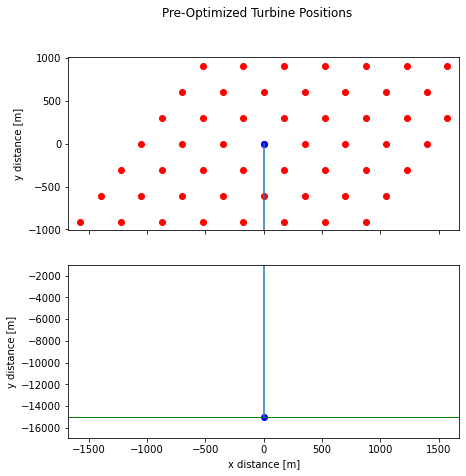

In [9]:
# Display pre-optimized turbine positions before clustering and MST

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)    
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

In [10]:
#Function to determine land cost of wind farm using a convex hull
#Calcualtes area of wind farm, onshore substation, and export cable
#Won't work for just 1 turbine since no boundary to enclose

def LandAreaCost(positionlist,ExportDistance):
    
    radius = 130 #m
    OnshoreSubLand = np.pi*radius**2 #Land area associated with the onshore substation
    ExportLand = ExportDistance*8 # Length*width 
    
    hull = ConvexHull(positionlist) #computes convex hull using the turbine positions
    LandArea = hull.volume + OnshoreSubLand + ExportLand #Calcualtes convex hull area and adds on the onshore substation land area

    LandCost = LandArea*LandCostpermSquared
    
    return LandCost

LandCost = LandAreaCost(positionlist,ExportDistance)

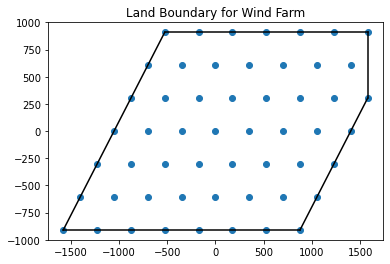

In [11]:
#Visual aid for convex hull plotting

hull = ConvexHull(positionlist)
plt.plot(positionlist[:,0], positionlist[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(positionlist[simplex, 0], positionlist[simplex, 1], 'k-')


plt.title('Land Boundary for Wind Farm')
plt.show()

C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Function run time: 0.2864892999999995
[[   0    6    7    8   21   22   23   45   46   47 -100]
 [   0   19   20   40   41   42   43   44 -100 -100 -100]
 [   0    1    2    3   13   14   15   32   33   34   35]
 [   0    4    5   16   17   18   36   37   38   39 -100]
 [   0    9   10   24   25   26   48   49   50   51 -100]
 [   0   11   12   27   28   29   30   31   52   53 -100]]


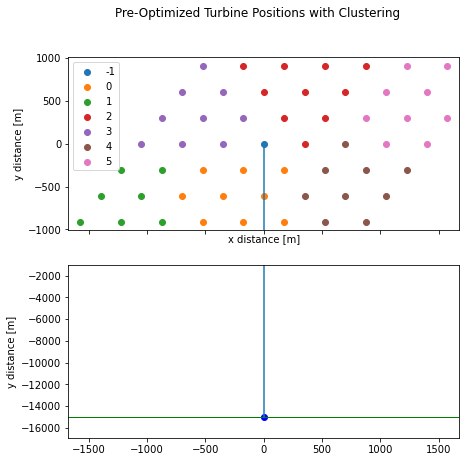

In [12]:
#CLUSTERING ALGORITHM

#Uses an adapted version of kmeans with a cap on the number of points per cluster. Used to radially cluster turbines
#into segments which MST algorithm can then use to determine cabling for a given radial array. Initially unnecessary
#for the initially structured turbine layout as seen above, but increasingly important as turbine layout becomes
#non-uniform through optimisation when the below function is repeatedly called.
# minsize_kmeans imported from external python file

def clustering_algorithm(positionlist,nturb,maxnodespertree):
    k = math.ceil(nturb/maxnodespertree) #number of clusters. math.ceil rounds a number upwards to its nearest integer
    [turbines, centres] = minsize_kmeans(positionlist[1:,:] ,k ,min_size = 1, max_size = maxnodespertree) 
    #turbines exists as an array containing the cluster value for each turbine
    #Assigns each turbine to a cluster. excludes substation, executes external python file, 
    #limits for how many turbines are in each cluster between 1 and max nodes per tree 
    label = np.concatenate((np.array([-1]),turbines)) # Adds -1 (substation label) to the other turbine labels
    u_labels = np.unique(label) 
    # finds unique elements of label. Finds the unique cluster labels 
    # each turbine is assigned a cluster/label and this returns a single label for each cluster
    
    a = 0
    indiceslist = np.empty((k,maxnodespertree), dtype=np.int8) # empty array of no.clusters by max nodes per tree
# indiceslist basically tells us what turbines belong to each cluster
# each row of indiceslist represents a cluster and each point on that row a indidual turbine within that cluster
# Each row starts with a 0 which represents the subsation which belongs to all clusters
# As seen before in the initial layout numbers are assigned starting at 1 which is the turbine (a,0) from the substation
# The numbering then continues in a cyclic motion traveling anticlockwise up until the total number of turbines
    
    for i in range(k): # loops for number of clusters
        indices = [i for i, x in enumerate(label) if x == a] # enumerate exists as a counter in the loop (starts at x=a=0)

        if len(indices) < maxnodespertree:
            noofemptys = maxnodespertree - len(indices)
            for l in range(noofemptys): # For the empty spaces in the matrix replaces these with -100 as fillers
                indices.append(int(-100))
    
        indiceslist[i,:] = (indices)
        a += 1
    
    arr = np.zeros((k,1),dtype=np.int8)   # zero array of number of clusters by 1 (Substation array)
    indiceslist = np.concatenate((arr,indiceslist),axis=1) # Adds substation zero array to turbine cluster matrix
    return indiceslist,u_labels,label

t1_start = perf_counter() # Starts timer
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) #Executes clustering algorithm
t1_stop = perf_counter() # Ends timer
print('Function run time:', t1_stop-t1_start) # Prints algorithm run time

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustering')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
for i in u_labels: # loops for number of turbines
    ax1.scatter(positionlist[label == i , 0] , positionlist[label == i, 1] , label = i)
ax1.legend() # prints legend
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_xlabel('x distance [m]') # x axis label
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

print(indiceslist)

In [13]:
#CREATES INPUT NEEDED FOR MST ONCE CLUSTERS ARE DEFINED.

#distance_global - distances of each turbine with respect to the substation and each other h=sqrt(x^2+y^2)
#e.g. row 0 would be each turbines distance with respect to the substation
# and row 4 would be each turbines distance with respect to the 4th turbine as found in the position list
# distance_globl[i,i] = 1e10 since this is the distance of each turbine with respect to itself so we want the MST to ignore thse values
#angle_global - angle of each turbine with respect to the substation and each other arctan(y/x)
#distance and angle then do something similar but considering the cluster formations as well

def geom_analysis(positionlist,indiceslist):
    
    #Arrays for pairwise distances and angles
    #Angle 0: x directıon. Angle pi/2: y directıon
    distance = [None] * math.ceil(nturb/maxnodespertree) # null array with size based on number of clusters
    angle = [None] * math.ceil(nturb/maxnodespertree) 
    distance_global = np.zeros((nturb,nturb)) #zero array nturb by nturb. This will be for storing the distance between each pair of turbines for cabling
    angle_global = np.zeros((nturb,nturb)) # Like above this will be for storing the angle data between each pair of turbines for cabling
    coords = positionlist[1:,:] # Coordinates of each turbine

    for i in range(0,nturb): # loops for number of turbines
        distance_global[i,:]=np.sqrt(np.square(coords[i,0]-coords[:,0])+np.square(coords[i,1]-coords[:,1])) # Pythagoras for hypotenuse
        angle_global[i,:]=np.arctan2(coords[:,1]-coords[i,1],coords[:,0]-coords[i,0]) #Pythagoras for angle
        distance_global[i,i]=1e10
        #Rotate angles so that north=0 and convert to degrees
    angle_global=-np.rad2deg(angle_global)+270
    
    for x in range(0,math.ceil(nturb/maxnodespertree)): # loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1) # Everything except the -100 ones which were denoted earlier to show that there is no turbine at that index
        distance[x]=np.zeros((nturbintree,nturbintree))
        angle[x]=np.zeros((nturbintree,nturbintree))
    
        for i in range(0,nturbintree):
            for j in range(0,nturbintree):
                distance[x][i,j] = np.sqrt(np.square(positionlist[(indiceslist[x,i]),0]-positionlist[(indiceslist[x,j]),0]) + np.square(positionlist[(indiceslist[x,i]),1]-positionlist[(indiceslist[x,j]),1]))
                angle[x][i,j]=np.arctan2(positionlist[(indiceslist[x,j]),1]-positionlist[(indiceslist[x,i]),1],positionlist[(indiceslist[x,j]),0]-positionlist[(indiceslist[x,i]),0])
                distance[x][i,i]=1e10
        
        #Rotate angles so that north=0 and convert to degrees
        angle[x]=-np.rad2deg(angle[x])+270
      
    return distance,angle,distance_global,angle_global

In [14]:
# DETERMINES MINIMUM LENGTH OF CABLING REQUIRED TO CREATE COMPLETE CABLING NETWORK SUCH THAT ALL TURINES ARE CONNECTED
# IN ACCORDANCE WITH USER'S CONDITIONS.

def Minimum_Spanning_Tree(distance,indiceslist):

    MSTweight = [None] * math.ceil(nturb/maxnodespertree) # null array with sized based on number of clusters
   
    for x in range(0,math.ceil(nturb/maxnodespertree)): #loops for number of clusters
        nturbintree = np.count_nonzero(indiceslist[x,:] > -1)
        g=Graph(nturbintree) #Graph is part of the external python script titled Boruvka_Mod
        
        for i in range(0,nturbintree):
            for j in range(i+1,nturbintree):
                g.addEdge(i,j ,(distance[x][i,j]*1000))
           
        MSTweight[x]=g.boruvkaMST()
    return MSTweight

Each tree weight tree 1 3150000.0
Each tree weight tree 2 3026012.958872607
Each tree weight tree 3 3500000.0
Each tree weight tree 4 3150000.0
Each tree weight tree 5 3406217.7826491073
Each tree weight tree 6 3726012.958872607
MST total weight 19958243.70039432 m


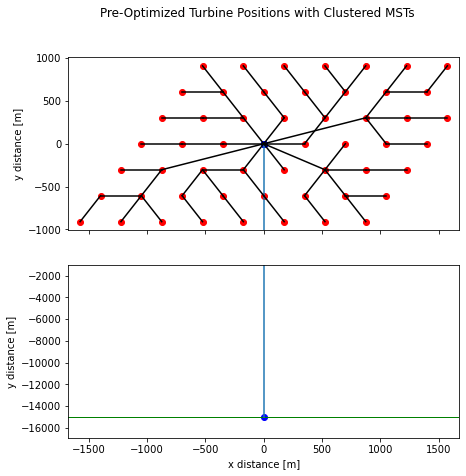

In [15]:
#PLOTTING PRE-OPTIMISED MST

# the Boruvka_mod code requires graphs with vertices 0....n, which is provided by the index value on indices list.
# When this is plotted, the values within the correct indiceslist row are then used to reference the index within
# positionlist to be plotted.

#

MSTweight=Minimum_Spanning_Tree(geom_analysis(positionlist, indiceslist)[0],indiceslist)

fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
fig.suptitle('Pre-Optimized Turbine Positions with Clustered MSTs')

#Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax1.set_ylabel('y distance [m]') # y axis label
ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 

#Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
ax2.set_xlabel('x distance [m]') # x axis label
ax2.set_ylabel('y distance [m]') # y axis label
ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits

links = [None] * math.ceil(nturb/maxnodespertree)
MSTWeightSum = 0 #MST weight is simply the total length of cabling used

for a in range(0,math.ceil(nturb/maxnodespertree)):
    MSTWeightSum += MSTweight[a][0]
    print('Each tree weight', 'tree',a+1 ,MSTweight[a][0])
    links[a] = MSTweight[a][1]
    
    for b in links[a]:
        u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
        v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
        ax1.plot(u,v, c='black')
        ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue')
        
print('MST total weight', MSTWeightSum, 'm')

In [16]:
#DISPLAYS RAW BATHYMETRY DATA

print(data) # Prints out bathymetry data - Read in using pandas in previous section

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...  MAG_RESSEN  MAG_DICORR  \
0 

In [17]:
#CONVERTS LATITUDE AND LONGITUDE IN BATHYMETRY DATA TO CENTERED EASTINGS AND NORTHINGS

data['easting'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[0], axis=1) #Converts lon/lat to easting and adds this onto the 'data' file
data['northing'] = data.apply(lambda row: utm.from_latlon(row['LAT'], row['LON'])[1], axis=1) #Converts lon/lat to northing and adds this onto the 'data' file

zero_east = min(data['easting']) + (max(data['easting']) - min(data['easting']))/2 +30000 # Determines centre of bathymrtry data in easting direction (+30,000 is simply to get a more interesting result from the current bathymetry data)
zero_north = min(data['northing']) + (max(data['northing']) - min(data['northing']))/2 # Determines centre of bathymetry data in northing direction   

data['centered_easting'] = data['easting'] - zero_east # Centres the data about (0,0) and adds this onto the 'data' file
data['centered_northing'] = data['northing'] - zero_north # Centres the data about (0,0) and adds this onto the 'data' file

print(data) 

      SURVEY_ID  TIMEZONE      DATE     TIME       LAT      LON  POS_TYPE  \
0        NSEA86         0  19860424  149.733  54.50260  4.42565       NaN   
1        NSEA86         0  19860424  150.700  54.50254  4.42011       NaN   
2        NSEA86         0  19860424  151.717  54.50247  4.41424       NaN   
3        NSEA86         0  19860424  152.683  54.50240  4.40861       NaN   
4        NSEA86         0  19860424  153.667  54.50234  4.40282       NaN   
...         ...       ...       ...      ...       ...      ...       ...   
18132    NSEA86         0  19860513  555.800  52.81589  4.07220       NaN   
18133    NSEA86         0  19860513  556.900  52.81516  4.07883       NaN   
18134    NSEA86         0  19860513  557.733  52.81459  4.08396       NaN   
18135    NSEA86         0  19860513  558.700  52.81396  4.08972       NaN   
18136    NSEA86         0  19860513  559.750  52.81325  4.09609       NaN   

       NAV_QUALCO  BAT_TTIME  CORR_DEPTH  ...   GRA_OBS  EOTVOS  FREEAIR  \

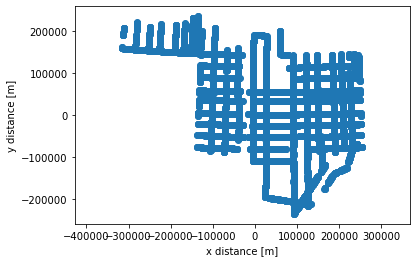

In [18]:
#PLOTS CENTERED BATHYMETRY DATA

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

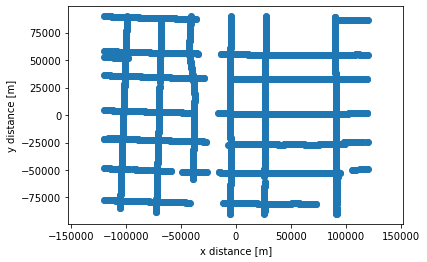

In [19]:
# SAMPLING AND PLOTTING CENTRAL BATHYMETRY DATA
# Takes sample between +/-120000 in easting direction, +/-90000 in the northing direction, and +/-1000 for the depth values

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data = data[(data['centered_easting'] >=-120000) & (data['centered_easting'] <= 120000) & (data['centered_northing']>=-90000) & (data['centered_northing']<= 90000) & (data['CORR_DEPTH']<=1000) & (data['CORR_DEPTH']>=-1000)]
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

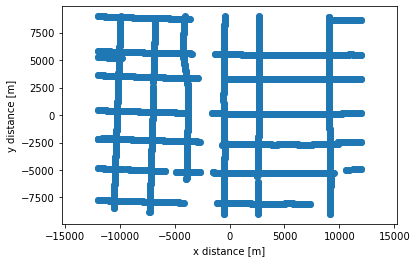

In [20]:
#FURTHER BATHYMETRY DATA PROCESSING
#Further decreases the area considered to be more applicable to the size of the wind farm (Sample from before divided by 10 in northing and easting directions)

fig, ax = plt.subplots()
plt.axis('equal')
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
data['centered_easting'] = data['centered_easting']/10
data['centered_northing'] = data['centered_northing']/10
ax.scatter(data['centered_easting'],data['centered_northing'])
plt.show()

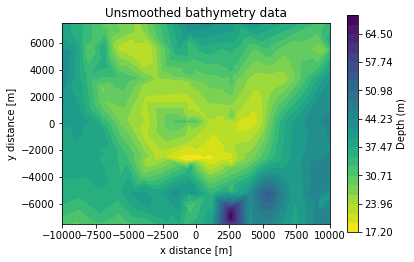

In [21]:
#UNSMOOTHED BATHYMETRY DATA CONTOUR PLOTTING

fig, ax = plt.subplots()
plt.xlim([-10000, 10000]) # x Limits of plot between +/-10000
plt.ylim([-7500, 7500]) # y Limits of plot between +/-7500
ax.set_aspect(aspect=1) # Sets the aspect of the axis scaling, i.e. the ratio of y-unit to x-unit.
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')

maxdepth = max(data['CORR_DEPTH'])
levels = np.linspace(mindepth,maxdepth,24) # Creates 24 even spaces or levels between the min and max depth

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], levels=levels, cmap = 'viridis_r') # (x,y,colour bar factor,level values,colour scale)
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Unsmoothed bathymetry data');

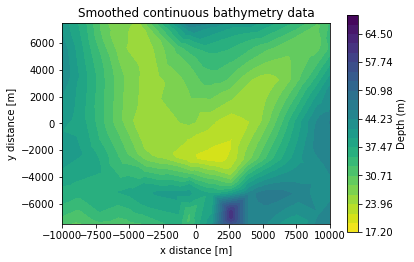

In [22]:
#SMOOTHING BATHYMETRY DATA

smooth = spline.SmoothBivariateSpline(data['centered_easting'], data['centered_northing'], data['CORR_DEPTH'], s = 25000)

fig, ax = plt.subplots()
plt.xlim([-10000, 10000])
plt.ylim([-7500, 7500])
ax.set_aspect(aspect=1)
ax.set_xlabel('x distance [m]')
ax.set_ylabel('y distance [m]')
levels = np.linspace(mindepth,maxdepth,24)

tcf = ax.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
cbar = plt.colorbar(tcf)
cbar.set_label('Depth (m)')
ax.set_title('Smoothed continuous bathymetry data');

In [23]:
# DETERMINING DEPTH AND ASSOCIATED COST FOR EACH TURBINE

def depthvalues(positionlist):
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    DepthCostPerTurbine = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    DepthCostAllTurbines = np.float64(0) # Assigns initial value to variable

    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1]) # Acquires depth assigned to each turbines position (x,y)
        DepthCostPerTurbine[i] = MinDepthCostPerTurbine = CostperTurbine*(0.0002*(float(DepthPerTurbine[i])**2) - 0.0002*(float(DepthPerTurbine[i])) + 0.9459)-CostperTurbine #Formula for depth cost
        DepthCostAllTurbines += DepthCostPerTurbine[i] # Sums up all turbines depth costs
        
    mindepth=float(min(DepthPerTurbine))
    maxdepth=float(max(DepthPerTurbine))
    return DepthCostAllTurbines, mindepth, maxdepth # returns respective values to user

depthvalues(positionlist)

(8141452.706531007, 22.346369891446553, 27.392063228618998)

In [24]:
#SETTING MODEL PARAMETERS

v0=8.0  #Incoming wind speed
nwind = 33
wind=np.arange(254,287)

#b=np.array((1,5,1000))
#b=np.array(( 1.40002561e-01,   8.51478121e+00,   2.62606729e+03))

# 3 model parameters below:

# 0th: how much power the turbine removes at the centre of the peak of the power distribution.
# 1st: how wide the angle of effect is. UNITS: degrees
# 2nd: up to how far back the effect takes place (approx. 2.6km) UNITS: [m]

model=np.array((1.39998719e-01, 8.51483871e+00, 2.62613638e+03))

ws=2.0 #weibull scale factor
wei_gamma=gamma(1.+1./ws)

Pr = 2*10**6 #Rated Power for Horns Rev 1 Turbines. Max power output [Watts]
Vc = 4.0 #Cut-in Velocity. Starts producing energy at wind speed of 4m/s [m/s]
Vr = 15.0 #Rated Velocity. Starts producing max energy at 15m/s
Vf = 25.0 #Cut-off Velocity. Turbines cut out at wind speeds of 25m/s to prevent damage to the turbines.
k = 2.0 #Weibull shape parameter
(Pr,Vc,Vr,k)

#interpolation parameters
dvel=1.5 #[m/s]
dang=5. #[degrees]

In [25]:
#DETERMINING WIND DIRECTION AND VELOCITY AT HORNS REV 1

v=np.loadtxt('hornsrev_data_all.txt') # assigns data to variable v.
vxref=v[:,3] # (INDEXING STARTS FROM 0). Third column of data is velocity of wind in x direction.
vyref=v[:,4] # (INDEXING STARTS FROM 0). Fourth column of data is velocity of wind in y direction.
angles=v[:,0] # Zeroth column of data is wind angle.
vmean=np.sqrt(np.square(vxref)+np.square(vyref)) # Uses pythagoras to find the wind magnitude + direction for each location.

vmean=pd.DataFrame(vmean) # organises vmean into labelled data structure
vref=pd.DataFrame()

vmean['angle']=angles # add another column to vmean (angle)
vref=vref.append(vmean) # add empty pandas data frame

vref=vref.groupby('angle')
vref.groups
vref.describe()
vref.get_group(260).iat[50,0] # data manipulation to group by angle etc.

6.512913707119303

In [26]:
#Arrays for pairwise distances and angles
#Angle 0: x direction. Angle pi/2: y directıon

# calculates distance and angle between each pair of turbines:

distance=np.zeros((nturb,nturb)) # 2x2 matrix of distances between turbines i and j where distance i-i and distance j-j = 0
# as they're distances to themselves: i-i i-j
                                 #    j-i j-j

angle=np.zeros((nturb,nturb)) # same as above but for angles between turbines.

for i in range(0,nturb):
   
    # 80x80 matrices as there's 80 turbines at Horns Rev 1.
    # squares y distance and x distance then sqrt to find overall distance between 2 turbines.
    distance[i,:]=np.sqrt(np.square(positionlist[i+1,0]-positionlist[1:,0])+np.square(positionlist[i+1,1]-positionlist[1:,1]))
    # same as above using arctan2 whilst giving correct quadrant (between 2 turbines).
    angle[i,:]=np.arctan2(positionlist[1:,1]-positionlist[i+1,1],positionlist[1:,0]-positionlist[i+1,0])
# Rotate angles so that north=0 and convert to degrees (and clockwise instead of anticlockwise)
angle=-np.rad2deg(angle)+270

# Rotating angles to wind direction
windangle=5 # degrees
rotangles=np.mod(angle-windangle+180,360)-180

In [27]:
# IMPORTING WIND DIRECTION DATA

#meteorological data where north = 0 degrees)
directiondata = pd.read_csv ('Directiondata.csv')
print (directiondata)
# velocity is the mean velocity with which wind from this direction blows
# c determines how wide the distribution is
# frequency/100 determines how often the wind is blowing at this angle

    Angle  Velocity     c  frequency
0       0      8.89  2.09       4.82
1      30      9.27  2.13       4.06
2      60      8.23  2.29       3.59
3      90      9.78  2.30       5.27
4     120     11.64  2.67       9.12
5     150     11.03  2.45       6.97
6     180     11.50  2.51       9.17
7     210     11.92  2.40      11.84
8     240     11.49  2.35      12.41
9     270     11.08  2.27      11.34
10    300     11.34  2.24      11.70
11    330     10.79  2.19       9.69
12    360      8.89  2.09       4.82


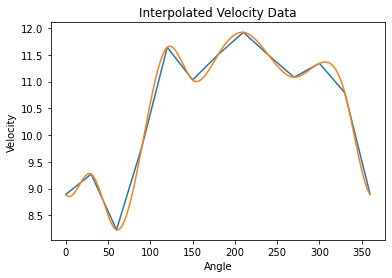

In [28]:
# interpolate 'velocity'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['Velocity']
wbvel = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360,0.10)
plt.plot(x,y, label='Line')
plt.plot(xs, wbvel(xs), label="Interpolated line ")
plt.title('Interpolated Velocity Data')
plt.xlabel('Angle')
plt.ylabel('Velocity')
plt.show()
# blue lines shows linear interpolation, orange shows smooth interpolation including across the
# periodic boundary.

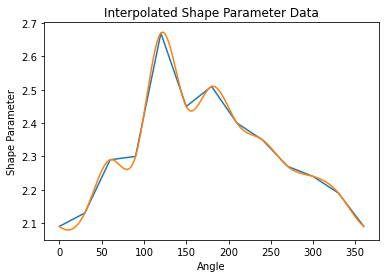

In [29]:
#interpolate 'c'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['c']
wbshape = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, wbshape(xs), label="S")
plt.title('Interpolated Shape Parameter Data')
plt.xlabel('Angle')
plt.ylabel('Shape Parameter')
plt.show()

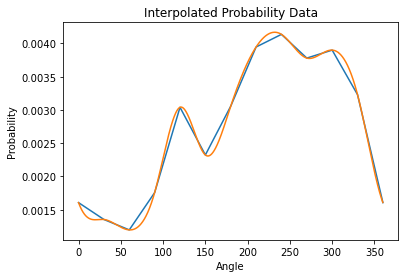

In [30]:
#interpolate 'frequency'
# info is only given every 30 degrees, giving a 'step function'
# interpolation gives higher resolution
# function is periodic as 360deg is the same as 0deg.
x = directiondata['Angle']
y = directiondata['frequency']/(100.*30.) #Data is in percent per 30 degrees, changing to probability per degree


windfreq = SP (x, y,bc_type='periodic')
xs = np.arange(0, 360, 0.1)
plt.plot(x,y)
plt.plot(xs, windfreq(xs), label="S")
plt.title('Interpolated Probability Data')
plt.xlabel('Angle')
plt.ylabel('Probability')
plt.show()
# plot shows wind direction is predominantly 200-320deg.

In [31]:
# Simple Attenuation fn
# Determines how much wind there is AFTER a turbine.
def att(dist, ang, model): 
        # 'Model' parameters are defined in 2ND CELL.

    # angular part
    angular=np.where(2.*model[1]*np.abs(ang)<np.pi,np.square(np.cos(model[1]*ang)),0.)
    # angular = np.cos(model[1]*ang WHEN 2.*model[1]*np.abs(ang) is less than pi, else angular = 0.
    
    # radial part (distance) (Gaussian Function)
    radial=np.exp(-np.square(dist/model[2])) # decreasing exponential of square, scaled by 2nd parameter
    penalty=np.exp(-np.square(dist/200))
    #penalty = 0
    return 1.0-1*model[0]*angular*radial-2*model[0]*penalty # OUTCOME

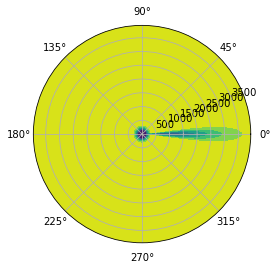

0.580003843


In [32]:
azimuths = np.radians(np.linspace(0, 360, 360)) # angles theta from 0 to 360 degress in 1 degree increments. Grid
zeniths = np.arange(0, 4000, 50) # distance from 0 to 4000 broken up into increments of 50.

r, theta = np.meshgrid(zeniths, azimuths)
values = att(r,np.mod(theta+np.pi,np.pi*2)-np.pi,model) # gets angles from -pi to pi, not from 0 to 2pi.

fig, ax = plt.subplots(subplot_kw=dict(projection='polar'))
ax.contourf(theta, r, np.maximum(values,0.85*np.ones(np.shape(values))))

plt.show()
print(np.min(values))

## Cell description:
# Polar plot is for 1 turbine, blue area shows where wind speed is affected. (Numbers label distance from turbine).
# Across the curve the distribution is the hump of cosine^2 function.
# Radially the distribution shown is Gaussian.
# Wake is currently too narrow close to the turbine as it treats the turbine as a point rather than accommodating
# for the blades' diameter.

In [33]:
# # isn't useful for continuing code, just rotates the windfarm.
# def rotate(angle,coords):
#     angle = np.pi*angle/180.
#     rotcoordx = []
#     rotcoordy = []
#     for coord in coords:
#         rotcoordx+=[coord[0]*np.cos(angle)-coord[1]*np.sin(angle)]
#         rotcoordy+=[coord[0]*np.sin(angle)+coord[1]*np.cos(angle)]
#     rotcoords=[rotcoordx,rotcoordy]
#     rotcoords=np.array(rotcoords).T   
#     return rotcoords 
# #print rotate(254,coords)[:,0]
# plt.scatter(rotate(0,coords)[:,0],rotate(0,coords)[:,1])

In [34]:
# returning total deviation between model and training set (between CFD data and the attenuation model)
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation(b):
    total_att=np.ones((nturb,nwind))
    deviation=0
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]*att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,b)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            deviation=deviation+np.square(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return deviation

In [35]:
# returning deviation for each turbine.
# This was relevant for earlier stages of the project when the wake model was being developed
#Total att
def deviation_sq(model):
    total_att=np.ones((nturb,nwind))
    dev_vec=np.zeros((nturb*nwind))
    for k in range(0,nwind):
        for j in range(0,nturb):
            for i in range(0,nturb):
                if (i!=j):
                    total_att[j,k] = total_att[j,k]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-wind[k])+np.pi,np.pi*2)-np.pi,model)
 #           print('{0} {1} {2}'.format(j,wind[k],total_att[j,k]))
            dev_vec[nturb*k+j]=(vref.get_group(wind[k]).iat[j,0]-v0*total_att[j,k])
    return dev_vec

In [36]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the % of wind that arrives at a turbine for a certain angle.
# Starts with assumption that there's zero wake so all turbines get full wind.
#talked about
#Total att
def windspeedreduction(distance,angle,direction,model): # vectors
    ndir=np.size(direction)
    total_att=np.ones((nturb,ndir)) # as many rows as there are turbines, as many columns as there are wind directions.
 #   power_vec=np.zeros((nturb,ndir))
    for j in range(0,nturb):
        for i in range(0,nturb):
            if (i!=j):
                # compounding wind speed reductions
                total_att[j,:] = total_att[j,:]* att(distance[i,j],np.mod(np.deg2rad(angle[i,j]-direction[:])+np.pi,np.pi*2)-np.pi,model)
  #      power_vec[j,:]=(v0*total_att[j,:])**3
    return total_att # matrix output that's needed. n turbine rows, n direction columns.
                     # Tells how much of 100% of wind arrives at a certain turbine from a certain direction.

In [37]:
# USEFUL OUTPUT USED IN TARGET FN
# Calculates the power produced by turbines when it sees a certain wind speed at a certain angle. 3D matrix
def power(wsr,v): # wind speed reduction, velocity
    nvel=np.size(v)
    nangle=np.size(wsr,1)
    power_vec=np.zeros((nturb,nangle,nvel))
    power_vec=POvec(np.outer(wsr,v)).reshape(nturb,nangle,nvel) # np.outer takes every wsr element and individually multiplies it with every element of v.
    return power_vec

In [38]:
#GIVES PROBABILITY OF WIND SPEED V AT A GIVEN ANGLE
def windspeedprobability(angles,v,d_angle,d_vel):
    nvel=np.size(v) 
    nangle=np.size(angles)
    wsprob=np.zeros((nangle,nvel))
    for i in range(angles.shape[0]):
        # Get Weibull parameters for angle and evaluate probability
        wsprob[i,:]=(wei(v[:],wbvel(angles[i]),wbshape(angles[i])))*windfreq(angles[i])*d_angle*d_vel
    return wsprob

In [39]:
# DEFINES WEIBULL DISTRIBUTION (shows the probability of any given wind speed occuring).

def wei(x,n,k): # convention to have in this order, scale parameter comes first (x) 
    u=n/gamma(1+1/k) #scaled wind speed
    return (k / u) * (x / u)**(k - 1) * np.exp(-(x / u)**k)
# k = Weibull shape parameter
# n = scale parameter
# x= value we are valuating

In [40]:
def wind_dist(v,vm):
    return wei(v,vm,k)

In [41]:
wind_dist(1.0,v0)

0.024244336764100854

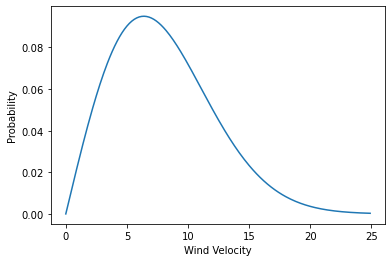

In [42]:
# PLOTS WEIBULL DISTRIBUTION

x=np.arange(0,25,0.1)
y=wind_dist(x,v0)

plt.xlabel('Wind Velocity')
plt.ylabel('Probability')
plt.plot(x,y)

In [43]:
velocities=np.arange(Vc,Vf,dvel) # 1D array ranging from Vc to Vf in dvel intervals. 4 to 25 in steps of 1.5
angles=np.arange(0,360,dang) # 0 to 360 with intervals of dang.
wsp=windspeedprobability(angles,velocities,dang,dvel) # tells probability of getting wind from a certain direction with a certain velocity.
# sum of all numbers would add up to 1.
print(wsp,np.shape(wsp),np.sum(wsp)) # wsp array, shape of wsp (rows,columns), sum of wsp elements
print(np.shape(velocities)) # shape of velocities array (rows, columns)
#plt.plot(x,y)

[[7.95303494e-04 9.80036676e-04 1.05789271e-03 ... 6.39190809e-05
  3.40253887e-05 1.70630457e-05]
 [7.34767202e-04 9.01764403e-04 9.69915308e-04 ... 5.75583274e-05
  3.06371248e-05 1.53701909e-05]
 [6.87320078e-04 8.44491359e-04 9.10294073e-04 ... 5.77144043e-05
  3.11157981e-05 1.58295009e-05]
 ...
 [9.80182139e-04 1.25683306e-03 1.41621103e-03 ... 1.55577912e-04
  9.05953796e-05 4.99151675e-05]
 [9.27369324e-04 1.17045619e-03 1.29626789e-03 ... 1.10756647e-04
  6.20462178e-05 3.28196113e-05]
 [8.63068120e-04 1.07416013e-03 1.17166708e-03 ... 8.08008629e-05
  4.38237311e-05 2.24068824e-05]] (72, 14) 0.9458659589195532
(14,)


In [44]:
# CALCULATES THE POWER CURVE OF A TURBINE

# Plots the power curve of a turbine.
# No power output from 0-4m/s, then cubic rise up to 15m/s and stays
# constant until cut-off velocity of 25m/s.

#cubic Based Power output
a=Pr/(Vr**3-Vc**3)
b=Vc**3/(Vr**3-Vc**3)

def q(v): # q is power output

    if (v<Vc): # below cut in velocity power is 0.
        q=0
    elif (v<Vr):
        q=a*v**3-b*Pr # cubic power output between cut in and max.
    elif (v<Vf):
        q=Pr # max power between max and cut off velocity.
    else: 
        q=0 # no power above cut off velocity.
    return q

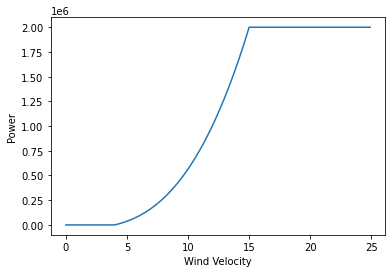

In [45]:
#PLOTS TURBINE POWER CURVE

x=np.arange(0,25,0.1)
POvec=np.vectorize(q) # vectorises power output function q (from cell above).
y=POvec(x)

plt.xlabel('Wind Velocity')
plt.ylabel('Power')
plt.plot(x,y)

In [46]:
wsr=windspeedreduction(distance,angle,angles,model)
print(wsr)
powout=power(wsr,velocities)
wsr

[[0.81179739 0.82462947 0.82156939 ... 0.85833169 0.82156939 0.82462947]
 [0.80118933 0.85731627 0.92293714 ... 0.92381428 0.92293714 0.85731627]
 [0.81179739 0.86866748 0.9351572  ... 0.93604595 0.9351572  0.86866748]
 ...
 [0.72958179 0.78438255 0.79676494 ... 0.77570557 0.79676494 0.78438255]
 [0.82264348 0.835647   0.83254603 ... 0.8697995  0.83254603 0.835647  ]
 [0.83355949 0.89195411 0.96022623 ... 0.96113881 0.96022623 0.89195411]]


array([[0.81179739, 0.82462947, 0.82156939, ..., 0.85833169, 0.82156939,
        0.82462947],
       [0.80118933, 0.85731627, 0.92293714, ..., 0.92381428, 0.92293714,
        0.85731627],
       [0.81179739, 0.86866748, 0.9351572 , ..., 0.93604595, 0.9351572 ,
        0.86866748],
       ...,
       [0.72958179, 0.78438255, 0.79676494, ..., 0.77570557, 0.79676494,
        0.78438255],
       [0.82264348, 0.835647  , 0.83254603, ..., 0.8697995 , 0.83254603,
        0.835647  ],
       [0.83355949, 0.89195411, 0.96022623, ..., 0.96113881, 0.96022623,
        0.89195411]])

In [47]:
# EXPECTED TURBINE OUTPUT (Watts) for the given wind distribution and positions.
# Can be seen that top left (NW) produces most energy for Horns Rev 1 Wind Farm.

# EXPECTED POWER FROM WIND FARM CALCULATIONS
# multiply the power that you'd get for each wind angle and speed condition by the probability of this occuring, for all angles and speed
# values and sum to find the expected power.
# Sum up this value for all turbines to find total wind farm expected power output.
output=np.zeros((nturb)) 
output=np.tensordot(powout,wsp,2)
print(output,np.shape(output),np.sum(output))
# last output is total power output in Watts.

[503502.22716545 471044.1376393  499301.33743877 518399.9848549
 543788.76776888 564520.06789718 551155.34307551 532408.39732911
 506505.73935734 480179.40137395 473313.14695766 480626.21624521
 472099.98972501 473532.39894528 489499.28159099 515460.37519422
 537176.4021089  562502.99240846 599696.47361685 643016.36771651
 611160.10641852 579860.30159301 554687.94114227 539372.07137639
 534913.35431563 504626.34296739 486048.08498374 486636.15463345
 517758.73776753 594831.30569128 540018.10795501 524080.17539073
 516657.23650697 525661.71711371 545819.65079304 593213.18487676
 589999.02221792 610072.30216936 635536.75976255 670087.17210117
 708491.9872631  779607.5076762  722565.73278198 695547.81997678
 666443.16318903 639833.58558923 618768.88905551 604976.77091086
 616388.09460284 565912.44938667 543739.74535329 533766.31421987
 557849.31081616] (53,) 29832660.149007462


In [48]:
# TURBINE OUTPUT (Watts) WITH NO INTERFERENCE

#Reference output:
# Same calculations as cell above except each turbine sees the full amount of wind every time
# (i.e. no wind reduction from other turbines).
refpowout=power(np.ones((nturb,np.size(angles))),velocities)
refoutput=np.zeros((nturb))
refoutput=np.tensordot(refpowout,wsp,axes=2)
print(refoutput,np.shape(refoutput),np.sum(refoutput))

# last output is total power output in Watts.

[867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078 867160.66008078 867160.66008078 867160.66008078
 867160.66008078] (53,) 45959514.98428145


In [49]:
# # assigns smaller interpolation intervals to dvel and dang to compare to coarser interpolations.
# dvel=0.1
# dang=0.1
# velocities=np.arange(Vc,Vf+dvel,dvel)
# angles=np.arange(0,360,dang)
# wsp=windspeedprobability(angles,velocities,dang,dvel)
# wsr=windspeedreduction(distance,angle,angles,model)
# powout=power(wsr,velocities)
# output=np.zeros((nturb)) 
# output=np.tensordot(powout,wsp,2)
# print (dvel,dang,np.sum(output))
# fineout=output

In [50]:
# # Calculates RMS error from changing interpolation value.
# velarray=np.array([1.5])
# angarray=np.array([5])
# rmserror=np.zeros((np.size(velarray),np.size(angarray)))
# i=0
# for dvel in velarray:
#     j=0
#     for dang in angarray:
#         velocities=np.arange(Vc,Vf+dvel,dvel)
#         angles=np.arange(0,360,dang)
#         wsp=windspeedprobability(angles,velocities,dang,dvel)
#         wsr=windspeedreduction(distance,angle,angles,model)
#         powout=power(wsr,velocities)
#         output=np.zeros((nturb)) 
#         output=np.tensordot(powout,wsp,2)
#         rmserror[i,j]=np.sqrt(np.sum(np.square(output-fineout))/np.size(output))
#         print (dvel,dang,np.sum(output),rmserror[i,j])
#         j+=1
#     i+=1
# print(rmserror)

In [51]:
distance,angle,distance_global, angle_global = geom_analysis(positionlist,indiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)

In [52]:
def foundationDepthCost(foundation,DepthPerTurbine):
    
    FoundationCost = foundation*(0.0002*(float(DepthPerTurbine)**2) - 0.0002*(float(DepthPerTurbine)) + 0.9459)
    
    return FoundationCost

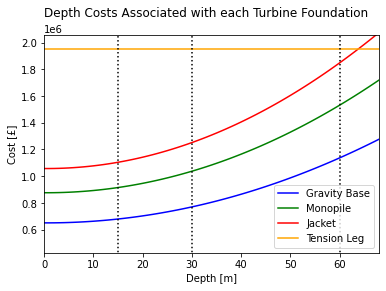

In [53]:
# Plots depth functions for each individual turbine foundation type

Depthx = range(0,math.ceil((max(data['CORR_DEPTH']))),1)
GBCost = [None] * len(Depthx)
MPCost = [None] * len(Depthx)
JCost = [None] * len(Depthx)
TLCost = [None] * len(Depthx)
Depth = 0

for i in Depthx:
    GBCost[i] = foundationDepthCost(GravityBase,Depth)
    MPCost[i] = foundationDepthCost(Monopile,Depth)
    JCost[i] = foundationDepthCost(Jacket,Depth)
    TLCost[i] = TensionLeg
    Depth += 1
    
fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with each Turbine Foundation')

x1 = np.linspace(15,15,100)
x2 = np.linspace(30,30,100)
x3 = np.linspace(60,60,100)
y = np.linspace(0,TensionLeg+500000,100)

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx,GBCost,'blue')
ax.plot(Depthx,MPCost,'green')
ax.plot(Depthx,JCost,'red')
ax.plot(Depthx,TLCost,'orange')
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

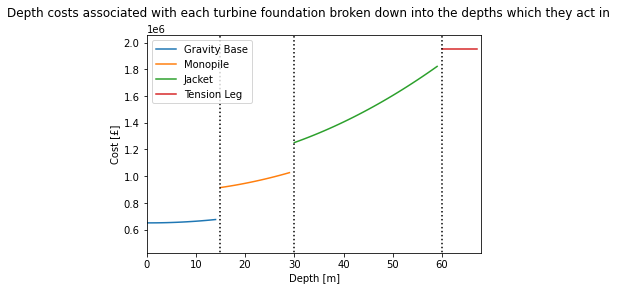

In [54]:
# Plots depth functions for each individual turbine foundation type but only considers the depths for which the foundation will act in

GBCost2 = GBCost[Depthx[0]:Depthx[15]]
MPCost2 = MPCost[Depthx[15]:Depthx[30]]
JCost2 = JCost[Depthx[30]:Depthx[60]]
TLCost2 = TLCost[Depthx[60]:max(Depthx)]

fig, ax = plt.subplots()
fig.suptitle('Depth costs associated with each turbine foundation broken down into the depths which they act in')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH']-1)))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:15],GBCost2)
ax.plot(Depthx[15:30],MPCost2)
ax.plot(Depthx[30:60],JCost2)
ax.plot(Depthx[60:max(Depthx)],TLCost2)
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')
plt.legend(['Gravity Base','Monopile','Jacket','Tension Leg'])

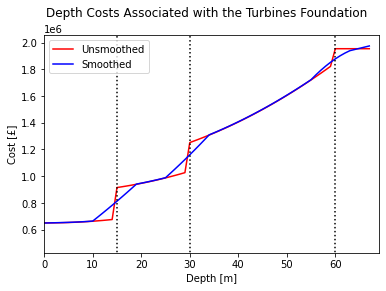

In [55]:
# Combines all the indivdual depths costs over there used depths into one plot and smooths the data

GBMPJTL = GBCost2+MPCost2+JCost2+TLCost2

fig, ax = plt.subplots()
fig.suptitle('Depth Costs Associated with the Turbines Foundation')

ax.set_xlabel('Depth [m]') # x axis label
ax.set_ylabel('Cost [£]') # y axis label
ax.set_xlim(0,math.ceil((max(data['CORR_DEPTH'])))) #x limits
ax.set_ylim(Monopile-500000,TensionLeg+100000) #y limits
ax.plot(Depthx[0:max(Depthx)],GBMPJTL,color='r')
smoothed_2dg = savgol_filter(GBMPJTL, window_length = 9, polyorder = 1)
ax.plot(Depthx[0:max(Depthx)], smoothed_2dg, color='b')
plt.legend(['Unsmoothed','Smoothed'])
ax.plot(x1,y,':',color='k')
ax.plot(x2,y,':',color='k')
ax.plot(x3,y,':',color='k')

In [56]:
def foundations(positionlist):
    
    DepthPerTurbine = [None] * (len(positionlist)-1) # none defines a null/no value. Get a null list the size of the np. turbines
    FoundationCost = [None] * (len(positionlist)-1) # Get a null list the size of the number of turbines
    FoundationCostTotal = 0 # Assigns initial value to variable
    
    for i in range(0,len(positionlist)-1): # loops for amount of turbines
        DepthPerTurbine[i] = spline.SmoothBivariateSpline.ev(smooth, positionlist[i+1,0], positionlist[i+1,1])
        
        FoundationCost[i] = np.interp(DepthPerTurbine[i],Depthx[0:max(Depthx)],smoothed_2dg)

        FoundationCostTotal += FoundationCost[i]
        
    return FoundationCostTotal

FoundationCostTotal = foundations(positionlist)

In [57]:
# Function for calculated payback time, discounted payback time, Net Present Value, and Profitability Index

def Payback(TPO,TotalCost,positionlist):
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation at positonlist[0,:]
    
    CashFlowYearly = (ElectricityCostperkWh*24*365*(TPO/1000))-(OperatingandMaintenanceCostsperAnnum*nturb) # Calculates the yaerly cash flow for the windfarm
    PayBackTime = TotalCost/CashFlowYearly # calculates payback time in years
    DiscountedPayBackTime = (np.log(1/(1-((TotalCost*DiscountRate)/CashFlowYearly))))/np.log(1+DiscountRate) #Calculates payback time but takes into account the time value of money
    
    l=0
    NPV = 0
    
    for l in range(LifeTimeTurbineOperatingTime):
        l+=1
        NPV = NPV + (CashFlowYearly)/((1+DiscountRate)**l) #NPV is a method used to determine the current value of future cash flows generated by the project
    
    NPV = NPV - TotalCost
    ProfIndex = (NPV+TotalCost)/TotalCost # Probability index >1 it's profitable <1 its not
    
    return PayBackTime,DiscountedPayBackTime,NPV,ProfIndex

In [58]:
#PLOTTING FUNCTION

def plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance):
    
    mindepth = depthvalues(positionlist)[1]
    maxdepth = depthvalues(positionlist)[2]
    
    nturb=np.size(positionlist,0)-1 # -1 due to the substation ar positonlist[0,:]
    links = [None] * math.ceil(nturb/maxnodespertree) # math.ceil rounds a number upwards to its nearest integer
    MSTWeightSum = 0

    fig, (ax1,ax2) = plt.subplots(2,sharex=True,figsize=(7,7))
    fig.suptitle('Plot Showing Sea Floor Topography and Turbines with Cables')
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    ax1.set_ylabel('y distance [m]') # y axis label
    ax1.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax1.set_ylim([min(positionlist[:,1])-100, max(positionlist[:,1])+100]) #y limits 
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    ax2.set_xlabel('x distance [m]') # x axis label
    ax2.set_ylabel('y distance [m]') # y axis label
    ax2.set_xlim([min(positionlist[:,0])-100, max(positionlist[:,0])+100]) #x limits
    ax2.set_ylim([min(positionlist[:,1])-DistanceToShore-1000, min(positionlist[:,1])-100]) #y limits
    
    for a in range(0,len(MSTweight)):
        MSTWeightSum += MSTweight[a][0]
        links[a] = MSTweight[a][1]
        for b in links[a]:
            u = positionlist[(indiceslist[a,b[0]])][0], positionlist[(indiceslist[a,b[1]])][0]
            v = positionlist[(indiceslist[a,b[0]])][1], positionlist[(indiceslist[a,b[1]])][1]
            ax1.plot(u,v, c='black')
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost=(MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal =(nturb)*CostperTurbine
    MaintenanceCosts=(nturb)*MaintenanceCostperTurbine 
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost=TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal 

    print('\033[1m'+'Maximum turbines per MST:'+'\033[0m', maximumturbinespertree)
    print('\033[1m'+'Number of turbines:'+'\033[0m', nturb)
    print()
    print('\033[1m'+'Inter-Array Cabling Costs: £'+'\033[0m', CableCost)
    print('\033[1m'+'Export Cabling Costs: £'+'\033[0m', ExportCableCost)
    print('\033[1m'+'Depth Cost: £'+'\033[0m', DepthCostAll)
    print('\033[1m'+'Foundations Cost: £'+'\033[0m', FoundationCostTotal)
    print('\033[1m'+'Turbine Cost: £'+'\033[0m', TurbineCostTotal)
    print('\033[1m'+'Land Cost: £'+'\033[0m', LandCost)
    print('\033[1m'+'Maintenance Cost: £'+'\033[0m', MaintenanceCosts)
    print('\033[1m'+'Fixed Cost:'+'\033[0m', FixedCost)
    print()
    print('\033[1m'+'Budget: £'+'\033[0m', budget)
    print('\033[1m'+'Total Cost: £'+'\033[0m', TotalCost)
        
    levels = np.linspace(mindepth-3,maxdepth+3,24) # Change to min(smooth) and max(smooth) somehow
    
    fig.subplots_adjust(left=0.1, right=0.8) #Adjusts plots to be able to fit a single color bar across both plots
    
    #Upper subplot (Shows wind farm, offshore substation, and upper part of export cable)
    tcf = ax1.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')
    cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8]) #Locates colorbar across both subplots
    cbar = plt.colorbar(tcf,cax=cb_ax) #plots colorbar with location as stated by cb_ax
    cbar.set_label('Depth (m)')    
    
    ax1.scatter(positionlist[:,0],positionlist[:,1],c='red') # Prints turbine positions in red
    ax1.scatter(positionlist[0,0],positionlist[0,1],c='blue') # offshore Substation
    ax1.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    #Lower subplot (Shows shoreline, onshore substation and lower part of export cable)
    tcf = ax2.tricontourf(data['centered_easting'], data['centered_northing'], smooth(data['centered_easting'], data['centered_northing'], grid=False), levels=levels, cmap = 'viridis_r')

    ax2.scatter(OnshoreSubstation[0],OnshoreSubstation[1],c='blue') #onshore substation
    ax2.plot(TXShoreLine,TYShoreLine,c='green',linewidth=1) #Produces line representing the shore line in green
    ax2.plot([positionlist[0,0],OnshoreSubstation[0]],[positionlist[0,1],OnshoreSubstation[1]]) #Plots Shore to substation connection
    
    fig, ax3 = plt.subplots()
    PieChartLabels = ['(Inter-Array) Cabling Costs', 'Depth Costs', 'Turbine Costs', 'Land Costs', '(Life time) Maintenance Costs', 'Fixed Costs','(Export) Cabling Costs','Foundation Costs'] # Titles for each segment of pie chart
    sizes = [CableCost,DepthCostAll,TurbineCostTotal,LandCost,MaintenanceCosts,FixedCost,ExportCableCost,FoundationCostTotal] # Figures for each segment of pie chart
    
    ax3.pie(sizes, labels=PieChartLabels, autopct='%1.1f%%') # Pie chart with brekadown of all associated costs
    ax3.axis('equal') #equal aspect ratio
    ax3.set_title('Wind Farm Costs') #Pie chart title
                                                                                                  
    return TotalCost

PRE-OPTIMISED LAYOUT INFORMATION

Maximum turbines per MST: 10
Number of turbines: 53

Inter-Array Cabling Costs: £ 6862952.371597778
Export Cabling Costs: £ 10507878.151260504
Depth Cost: £ 8141452.706531007
Foundations Cost: £ 53421547.986499526
Turbine Cost: £ 117690599.55588453
Land Cost: £ 7799405.645705766
Maintenance Cost: £ 69430000.0
Fixed Cost: 17035714.285714284

Budget: £ 300000000.0
Total Cost: £ 290889550.70319337
Total Power Output: 29832660.149007462 W
Theoretical Max Total Power Output: 45959514.98428145 W
Percentage power lost to wake effcts: 35.08926245368236 %
Cost per Watt 9.75070775620629 £/W

Payback Time: 8.5153498059472 years
Discounted Payback Time: 13.398505745914774 years
NPV: £ 71008446.94208783 over a  20 year period
Profitability Index: £ 1.244107932960922 over a  20 year period


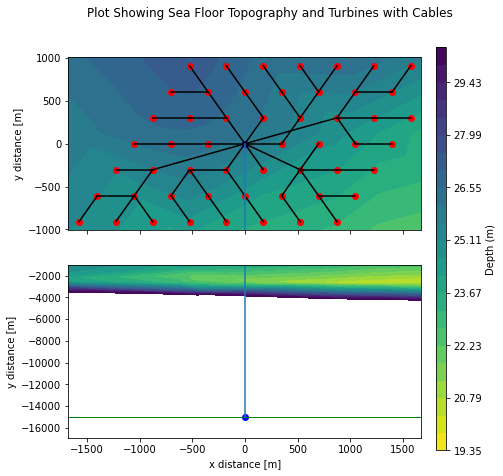

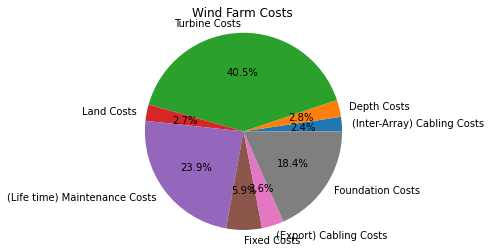

In [59]:
## Below calculates max theoreticl power output
wsr_noWake = np.ones(wsr.shape)
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power_pre = np.sum(output_noWake)

#DISPLAYING PRE-OPTIMISED LAYOUT AND ASSOCIATED INFO
print('\033[1m'+'\033[4m'+'PRE-OPTIMISED LAYOUT INFORMATION'+'\033[0m'+'\033[0m')
print()
MSTweight = Minimum_Spanning_Tree(distance,indiceslist)
TotalCost = plotting_function(positionlist,indiceslist,MSTweight,data,OnshoreSubstation,ExportDistance)

PayBackTime,DiscountedPayBackTime,NPV,ProfIndex = Payback((np.sum(output)),TotalCost,positionlist)

# print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
# print('\033[1m'+'Cost per Watt:'+'\033[0m',TotalCost/np.sum(output),'£/W')
# print('')
# print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
# print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
# print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
# print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

print('\033[1m'+'Total Power Output:'+'\033[0m', np.sum(output), 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power_pre, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(np.sum(output)/theoretical_max_power_pre))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',TotalCost/np.sum(output),'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',PayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',DiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',NPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',ProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [60]:
#REDUCING NO. OF TURBINES PRE-OPTIMISATION
overspend = TotalCost - budget
if overspend > 0:
    nturbstoremove = math.floor(overspend/(MinCostperTurbTot))
    ### It can be safely assumed that this many turbines at minimum can be removed.
    print('Number of removed turbines:', nturbstoremove)
    for amount in range(0,nturbstoremove):
        nturb = nturb - 1
        positionlist = np.delete(positionlist, len(positionlist)-1, 0)
    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)
    print('new number of turbines:', nturb)

In [61]:
v=2
for amount in range(0,v):
    nturb = nturb - 1
    positionlist = np.delete(positionlist, len(positionlist)-1, 0)
indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree)

C:\Users\adamb\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [62]:
#TARGET FUNCTION

# analyses the coordinates to collate the distances and angles between all of them
# calculates the minimum spanning tree length and adds the assumption of cabling costs,
# turbines costs, maintenance costs and fixed costs.

smallestindiceslist = []
smallestTotalCost = None
smallestCostPerWatt = 10000000000000.0
smallestpositionlist = []
smallestExportDistance = None

def targetfunction(coord_flat):
    
    #Global variables are used instead of res.x as res.x only holds the coordinates, not the other associated parameters,
    #inc. the optimal clustering, which will not necessarily be the same if the clustering algorithm is run again as the
    #start position is random for clustering. Additionally, res.x only provides an approximate minimization, whereas
    #storing values as global variables and finding the minimum guarantees that the minimum value found is returned.
    
    global smallestindiceslist
    global smallestTotalCost
    global smallestCostPerWatt
    global smallestpositionlist
    global smallestExportDistance

    arr2=np.reshape(coord_flat,(-1,2)) # undoes the coordinate flattening
    hull = ConvexHull(arr2)
    arr1 = np.array([np.mean(hull.points[hull.vertices,0]),np.mean(hull.points[hull.vertices,1])])
    arr1 = np.reshape(arr1,(-1,2))
    positionlist = np.concatenate((arr1,arr2),axis=0)
    #positionlist = np.reshape(coord_flat,(-1,2))#np.concatenate((arr1,arr2),axis=0) #np.reshape(coord_flat,(-1,2))
    
    nturb=np.size(positionlist,0)-1 # determines number of turbines (-1 due to the substation)
    print('nturb', nturb)
    
    OnshoreSubstation,ExportDistance = Substation_To_Shore_Connection(positionlist)

    indiceslist,u_labels,label = clustering_algorithm(positionlist,nturb,maxnodespertree) # calls clustering function
    distance,angle,distance_global,angle_global = geom_analysis(positionlist,indiceslist) # calls pre-MST function
    
    MSTweight=Minimum_Spanning_Tree(distance,indiceslist) # Calls MST function
    MSTWeightSum=0
    
    for a in range(0,math.ceil(nturb/maxnodespertree)): 
        MSTWeightSum += MSTweight[a][0] 
        
    wsr=windspeedreduction(distance_global,angle_global,angles,model) # calls wake attenuation function
    powout=power(wsr,velocities) # total output power
    output=np.tensordot(powout,wsp,axes=2) # reduced power output due to wake effects
    
    FoundationCostTotal = foundations(positionlist)
    ExportCableCost = (ExportDistance*ExportCableCostperMeter) # Export cable cost
    FixedCost = (OffshoreSubstationCostperMW+OnshoreSubstationCostperMW)*TurbineRating*nturb
    CableCost= (MSTWeightSum/1000)*IACableCostperMeter
    DepthCostAll = depthvalues(positionlist)[0]
    TurbineCostTotal= (nturb)*CostperTurbine
    MaintenanceCosts= (nturb)*MaintenanceCostperTurbine
    LandCost = LandAreaCost(positionlist,ExportDistance)
    TotalCost= TurbineCostTotal+DepthCostAll+MaintenanceCosts+FixedCost+LandCost+CableCost+ExportCableCost+FoundationCostTotal

    print('Total power output in Watts', np.sum(output),'Total Cost in £', TotalCost, '£/W', (TotalCost/(np.sum(output))))###

    CostperWatt = TotalCost/(np.sum(output))
    
    if CostperWatt < smallestCostPerWatt:
        smallestCostPerWatt = CostperWatt
        smallestindiceslist = indiceslist
        smallestTotalCost = TotalCost
        smallestpositionlist = positionlist
        smallestExportDistance = ExportDistance

    print('smallest cost per watt',smallestCostPerWatt)
    
    return CostperWatt

In [63]:
# OPTIMIZATION

#xright = 0
#xleft = 0
#yup = 0
#ydown = 0
#for xright in range(0,nturb+1):
 #   if positionlist[xright,0]>0:
  #      positionlist[xright,0] = positionlist[xright,0] + 250
#for xleft in range(0,nturb+1):
 #   if positionlist[xleft,0]<0:
  #      positionlist[xleft,0] = positionlist[xleft,0] - 250
#for yup in range(0,nturb+1):
 #   if positionlist[yup,1]>0:
  #      positionlist[yup,1] = positionlist[yup,1] + 250
#for ydown in range(0,nturb+1):
 #   if positionlist[ydown,1]<0:
  #      positionlist[ydown,1] = positionlist[ydown,1] - 250
        
        
t1_start = perf_counter() # timer starts

while True:  
    
    iteration_time_start = perf_counter()
    
    #flat_coords=positionlist.flatten() # turns 2D coords into single list of data without any more structure.
    flat_coords=positionlist[1:,:].flatten() # turns 2D coords into single list of data without any more structure.
    dvel=1.5
    dang=5
    velocities=np.arange(Vc,Vf,dvel)
    angles=np.arange(0,360,dang)        
            
    # b = (Lower bound, Upper bound)
    b2 = ((min(positionlist[:,0]))-1000,(max(positionlist[:,0]))+1000) #bounds for x coordinates
    #b3 = ((OnshoreSubstation[1]+((TooCloseShore-2500))),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    b3 = (((min(positionlist[:,1]))-1000),(max(positionlist[:,1]))+1000) #bounds for y coordinates of turbines
    bnd = (b2,b3) #bounds for x,y coordinates of each turbine 
    bnd1 = (bnd*(nturb)) #repeats bnd for the amount of turbines 
    bnds = bnd1 #Combines all bounds into a list for use in the optimization function
    
    #res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, bounds=bnds, options={'disp': 2, 'eps': 50, 'ftol': 1e-17, 'gtol': 1e-17})
    res = minimize(targetfunction, flat_coords, method='L-BFGS-B', jac=False, options={'disp': 2, 'eps': 50})#, 'ftol': 1e-17, 'gtol': 1e-17})

    #res = minimize(targetfunction, flat_coords, method='Nelder-Mead', jac=False, bounds=bnds, options={'disp': 2, 'xatol': 1e-3, 'fatol': 1e-3})#, 'ftol': 1e-17, 'gtol': 1e-17})
    #res = minimize(targetfunction, flat_coords, method='TNC', jac=False, bounds=bnds, options={'disp': 2, 'eps':50})#, 'ftol': 1e-17, 'gtol': 1e-17})
    
    iteration_time_end = perf_counter()
    print(iteration_time_end-iteration_time_start)
    
    if smallestTotalCost<=budget: #if under budget
        if not res.success:
            print(res.status, res.message) 
        else:
            break # Stops optimization when minimization is under budget after an iteration of 'minimize' 
    else: # over budget then removes a turbine and resets approrate varaibles 
        nturb = nturb - 1 
        smallestindiceslist = []
        smallestTotalCost = None
        smallestCostPerWatt = 10000000000000.0
        smallestpositionlist = []
        smallestExportDistance = None
        
        wsr=windspeedreduction(distance_global,angle_global,angles,model)
        powout=power(wsr,velocities) # total output power
        outputs=np.tensordot(powout,wsp,axes=2)
        LowestPower = min(outputs)
        LowestPowerIndex = np.argmin(outputs)
        LowestPowerTurbine = positionlist[LowestPowerIndex+1,:]
        positionlist = np.delete(positionlist, LowestPowerIndex+1, 0) 

        # CANNOT USE CALLBACK as this only returns targetfunction output and not the other variables that are needed too.
          
t1_stop = perf_counter() # timer ends
totaltime = t1_stop - t1_start # total run time in seconds
print('Total function time:', totaltime)

nturb 51
Total power output in Watts 29048031.745524537 Total Cost in £ 280500875.338077 £/W 9.656450316338356
smallest cost per watt 9.656450316338356
nturb 51
Total power output in Watts 28995985.27771156 Total Cost in £ 280403575.98522556 £/W 9.670427588496684
smallest cost per watt 9.656450316338356
nturb 51
Total power output in Watts 29013791.748675067 Total Cost in £ 280479754.13076663 £/W 9.667118195386335
smallest cost per watt 9.656450316338356
nturb 51
Total power output in Watts 29017960.128298625 Total Cost in £ 280414803.5420839 £/W 9.663491241364703
smallest cost per watt 9.656450316338356
nturb 51
Total power output in Watts 29017315.57330086 Total Cost in £ 280334483.0799295 £/W 9.660937875930474
smallest cost per watt 9.656450316338356
nturb 51
Total power output in Watts 29003921.21057985 Total Cost in £ 280360133.2710199 £/W 9.666283784026831
smallest cost per watt 9.656450316338356
nturb 51
Total power output in Watts 28997716.079195622 Total Cost in £ 280376771.69

Total power output in Watts 29018875.23571225 Total Cost in £ 280578069.8851532 £/W 9.668812716071715
smallest cost per watt 9.64753357444155
nturb 51
Total power output in Watts 29077359.206801545 Total Cost in £ 280438487.63090086 £/W 9.64456523153942
smallest cost per watt 9.64456523153942
nturb 51
Total power output in Watts 29003784.2014935 Total Cost in £ 280354492.6145816 £/W 9.666134965938175
smallest cost per watt 9.64456523153942
nturb 51
Total power output in Watts 29078981.5616131 Total Cost in £ 280381877.5446813 £/W 9.64208037859245
smallest cost per watt 9.64208037859245
nturb 51
Total power output in Watts 29007806.506371904 Total Cost in £ 280405987.20554554 £/W 9.666569829881865
smallest cost per watt 9.64208037859245
nturb 51
Total power output in Watts 29084026.333880335 Total Cost in £ 280431071.7608621 £/W 9.642099362088135
smallest cost per watt 9.64208037859245
nturb 51
Total power output in Watts 29071711.823015787 Total Cost in £ 280397562.33731157 £/W 9.64503

Total power output in Watts 29002269.869392477 Total Cost in £ 280249520.5102298 £/W 9.66302023159887
smallest cost per watt 9.63703361656747
nturb 51
Total power output in Watts 29036291.571679585 Total Cost in £ 280268775.3057149 £/W 9.65236123951427
smallest cost per watt 9.63703361656747
nturb 51
Total power output in Watts 29001290.5212181 Total Cost in £ 280189739.6406672 £/W 9.661285225761699
smallest cost per watt 9.63703361656747
nturb 51
Total power output in Watts 29060319.62144478 Total Cost in £ 280300004.4221399 £/W 9.645454973430342
smallest cost per watt 9.63703361656747
nturb 51
Total power output in Watts 29018372.037433606 Total Cost in £ 280279309.0182852 £/W 9.658684803431626
smallest cost per watt 9.63703361656747
nturb 51
Total power output in Watts 29017643.42704673 Total Cost in £ 280241725.667326 £/W 9.657632135837694
smallest cost per watt 9.63703361656747
nturb 51
Total power output in Watts 29016558.799922947 Total Cost in £ 280223887.9711901 £/W 9.65737839

Total power output in Watts 29035550.67187261 Total Cost in £ 280210434.67971236 £/W 9.65059825612877
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29090727.703112718 Total Cost in £ 280477540.3040491 £/W 9.641475564533158
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29033651.561995927 Total Cost in £ 280163153.491428 £/W 9.649601011887604
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29089732.541044734 Total Cost in £ 280505875.1747927 £/W 9.642779450756633
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29032529.979684483 Total Cost in £ 280289658.61061555 £/W 9.654331152219537
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29089987.90778672 Total Cost in £ 280386654.9348339 £/W 9.638596475998563
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29030147.063287053 Total Cost in £ 280067811.863831 £/W 

Total power output in Watts 29034633.338691078 Total Cost in £ 280189614.84214324 £/W 9.650186092371523
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29052848.66563928 Total Cost in £ 280340587.6242795 £/W 9.649332182555906
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29068417.096079506 Total Cost in £ 280343203.1008475 £/W 9.6442541805504
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29026009.900087636 Total Cost in £ 280317165.08146363 £/W 9.657447442702667
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29070397.70308175 Total Cost in £ 280298498.60661197 £/W 9.64205930271458
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29039187.23197593 Total Cost in £ 280180340.47679496 £/W 9.64835338670498
smallest cost per watt 9.635924307754848
nturb 51
Total power output in Watts 29037770.772621714 Total Cost in £ 280441891.2006433 £/W 

Total power output in Watts 29107504.33211194 Total Cost in £ 280433822.6384338 £/W 9.634416590262395
smallest cost per watt 9.631377654576873
nturb 51
Total power output in Watts 29047983.408270832 Total Cost in £ 280180246.2720929 £/W 9.645428473782355
smallest cost per watt 9.631377654576873
nturb 51
Total power output in Watts 29107769.977184854 Total Cost in £ 280546585.0295566 £/W 9.638202625946734
smallest cost per watt 9.631377654576873
nturb 51
Total power output in Watts 29044874.824595895 Total Cost in £ 280176281.8679671 £/W 9.646324301962808
smallest cost per watt 9.631377654576873
nturb 51
Total power output in Watts 29109886.9783029 Total Cost in £ 280452113.707126 £/W 9.634256358197524
smallest cost per watt 9.631377654576873
nturb 51
Total power output in Watts 29022873.914900906 Total Cost in £ 280345352.3627679 £/W 9.65946216025261
smallest cost per watt 9.631377654576873
nturb 51
Total power output in Watts 29110689.92201391 Total Cost in £ 280523916.47733533 £/W 9.

Total power output in Watts 29108376.363000657 Total Cost in £ 280278693.53308 £/W 9.628798598651459
smallest cost per watt 9.619184018170277
nturb 51
Total power output in Watts 29106520.047305148 Total Cost in £ 280459104.56457233 £/W 9.635610993988918
smallest cost per watt 9.619184018170277
nturb 51
Total power output in Watts 29108369.765717804 Total Cost in £ 280392685.4140708 £/W 9.632716901387637
smallest cost per watt 9.619184018170277
nturb 51
Total power output in Watts 29109330.242349595 Total Cost in £ 280323534.8524759 £/W 9.630023518873282
smallest cost per watt 9.619184018170277
nturb 51
Total power output in Watts 29113233.906912826 Total Cost in £ 280343180.99594676 £/W 9.62940708999629
smallest cost per watt 9.619184018170277
nturb 51
Total power output in Watts 29110375.257513534 Total Cost in £ 280314057.39543444 £/W 9.629352246947898
smallest cost per watt 9.619184018170277
nturb 51
Total power output in Watts 29117123.56535925 Total Cost in £ 280397241.2598688 £/

Total power output in Watts 29092352.87974003 Total Cost in £ 280353394.42738324 £/W 9.636669663202865
smallest cost per watt 9.6089728048562
nturb 51
Total power output in Watts 29177624.652285185 Total Cost in £ 280518465.3091346 £/W 9.61416388935432
smallest cost per watt 9.6089728048562
nturb 51
Total power output in Watts 29074361.715272967 Total Cost in £ 280308736.5230479 £/W 9.64109682847482
smallest cost per watt 9.6089728048562
nturb 51
Total power output in Watts 29144516.43791445 Total Cost in £ 280256329.245467 £/W 9.61609124112549
smallest cost per watt 9.6089728048562
nturb 51
Total power output in Watts 29072185.752359588 Total Cost in £ 280381423.18848425 £/W 9.64431864796157
smallest cost per watt 9.6089728048562
nturb 51
Total power output in Watts 29140459.623211246 Total Cost in £ 280425785.5627698 £/W 9.623245109675699
smallest cost per watt 9.6089728048562
nturb 51
Total power output in Watts 29071692.914667737 Total Cost in £ 280243832.90455145 £/W 9.63974935092

Total power output in Watts 29807415.021113712 Total Cost in £ 280817070.9336948 £/W 9.421047438524324
smallest cost per watt 9.420685461067348
nturb 51
Total power output in Watts 29792866.581772927 Total Cost in £ 280645669.4704306 £/W 9.41989481610097
smallest cost per watt 9.41989481610097
nturb 51
Total power output in Watts 29785078.955481708 Total Cost in £ 280842640.88755554 £/W 9.428970838295148
smallest cost per watt 9.41989481610097
nturb 51
Total power output in Watts 29803003.91697977 Total Cost in £ 280821299.5294028 £/W 9.422583720475554
smallest cost per watt 9.41989481610097
nturb 51
Total power output in Watts 29784584.171909638 Total Cost in £ 280694031.61894816 £/W 9.424138003701781
smallest cost per watt 9.41989481610097
nturb 51
Total power output in Watts 29796803.011354715 Total Cost in £ 280998337.9544389 £/W 9.430486144683321
smallest cost per watt 9.41989481610097
nturb 51
Total power output in Watts 29790475.546255447 Total Cost in £ 280747604.9726505 £/W 9.

Total power output in Watts 29757178.677655615 Total Cost in £ 280784978.58623236 £/W 9.43587366355639
smallest cost per watt 9.41167153619456
nturb 51
Total power output in Watts 29803045.940152977 Total Cost in £ 280842120.9462321 £/W 9.423269068208219
smallest cost per watt 9.41167153619456
nturb 51
Total power output in Watts 29764471.297498588 Total Cost in £ 280678666.81689155 £/W 9.429990004239714
smallest cost per watt 9.41167153619456
nturb 51
Total power output in Watts 29807895.241691373 Total Cost in £ 280864364.9974316 £/W 9.422482289343105
smallest cost per watt 9.41167153619456
nturb 51
Total power output in Watts 29754740.510781966 Total Cost in £ 280790622.39234376 £/W 9.436836536705675
smallest cost per watt 9.41167153619456
nturb 51
Total power output in Watts 29791610.39176795 Total Cost in £ 280857699.18198246 £/W 9.427409109095672
smallest cost per watt 9.41167153619456
nturb 51
Total power output in Watts 29764192.86132235 Total Cost in £ 280815739.1502067 £/W 9.

Total power output in Watts 30486791.856223382 Total Cost in £ 287329191.65075177 £/W 9.424710642097233
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30464313.15824717 Total Cost in £ 287502304.1369621 £/W 9.437347319912602
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30463908.36032885 Total Cost in £ 287245924.4835704 £/W 9.429056872349049
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30418141.46516926 Total Cost in £ 287374162.71824056 £/W 9.447459603911126
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30468460.316656057 Total Cost in £ 287407114.53497803 £/W 9.432938571492649
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30461135.15061543 Total Cost in £ 287541356.1954185 £/W 9.439613946547524
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30463788.424273726 Total Cost in £ 287754148.6161587 £/

Total power output in Watts 30411243.411013097 Total Cost in £ 287385542.9949173 £/W 9.449976744155215
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30453237.49104318 Total Cost in £ 287464265.5002512 £/W 9.439530545308996
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30454686.848318428 Total Cost in £ 287336060.7995962 £/W 9.43487162520148
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30402279.979322985 Total Cost in £ 287297015.86447775 £/W 9.449850999986595
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30463361.515552137 Total Cost in £ 287420599.7246567 £/W 9.434960077466268
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30473160.686842058 Total Cost in £ 287494548.43567806 £/W 9.434352786378826
smallest cost per watt 9.391087405045571
nturb 51
Total power output in Watts 30452012.07641096 Total Cost in £ 287461498.50726306 £

Total power output in Watts 30940627.8353413 Total Cost in £ 282943985.3562325 £/W 9.14473962396605
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30969772.794871952 Total Cost in £ 283123753.13132197 £/W 9.141938334730122
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30953267.28819351 Total Cost in £ 283334733.4979811 £/W 9.15362927150677
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30958853.755220447 Total Cost in £ 282984447.26868486 £/W 9.140662942695885
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30917896.784759883 Total Cost in £ 282930564.5045842 £/W 9.151028819141635
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30960794.155897092 Total Cost in £ 283108269.14399415 £/W 9.144089383445955
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30928023.743964396 Total Cost in £ 282980215.71667075 £/

Total power output in Watts 30962003.238830104 Total Cost in £ 283027290.6457428 £/W 9.14111688648079
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30952933.123782035 Total Cost in £ 283005186.1723298 £/W 9.14308136939981
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30936903.54167953 Total Cost in £ 283169179.70593405 £/W 9.153119649626095
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30956554.37173495 Total Cost in £ 282968342.6140168 £/W 9.14082165657243
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30956195.543038413 Total Cost in £ 282900902.25465924 £/W 9.138749038503196
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30945662.643668406 Total Cost in £ 282989573.42663324 £/W 9.14472495500218
smallest cost per watt 9.128464469705294
nturb 51
Total power output in Watts 30918503.7988231 Total Cost in £ 282837734.42578506 £/W 9

Total power output in Watts 31992941.02458958 Total Cost in £ 285562114.4979367 £/W 8.925785043596193
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32043008.62442649 Total Cost in £ 285581260.0376043 £/W 8.912435888429801
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32057509.96018161 Total Cost in £ 285710353.22763014 £/W 8.912431239435278
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32005370.21800216 Total Cost in £ 285597270.84858775 £/W 8.923417192279405
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32053962.130965278 Total Cost in £ 285730456.16663444 £/W 8.914044853463173
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32067472.591957174 Total Cost in £ 285571742.91503584 £/W 8.905339892195306
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32049059.23555853 Total Cost in £ 285861573.5193999 £/

Total power output in Watts 32047317.80561268 Total Cost in £ 285565077.6104291 £/W 8.910732540631404
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32035785.782033335 Total Cost in £ 285717257.9658977 £/W 8.91869048912597
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32044818.878224574 Total Cost in £ 285817428.15130484 £/W 8.919302344552381
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32080349.850728545 Total Cost in £ 285788995.9708329 £/W 8.90853738505419
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32053725.406288832 Total Cost in £ 285437713.13499063 £/W 8.904977799522445
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32060217.6061267 Total Cost in £ 285749997.9576662 £/W 8.912915110815076
smallest cost per watt 8.893663695039503
nturb 51
Total power output in Watts 32043036.996994216 Total Cost in £ 285651346.0718473 £/W 

Total power output in Watts 32423180.951859362 Total Cost in £ 285470995.1831791 £/W 8.804533879850807
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32424821.31682004 Total Cost in £ 285427453.35441184 £/W 8.802745605458412
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32406323.52771122 Total Cost in £ 285466457.32921505 £/W 8.808973874654669
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32408650.841652725 Total Cost in £ 285392881.4988781 £/W 8.806071036196338
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32464706.440407015 Total Cost in £ 285548176.6320393 £/W 8.79564942797799
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32428507.127984498 Total Cost in £ 285489752.3390367 £/W 8.803666206782319
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32445821.709133297 Total Cost in £ 285469681.9380588 £/

Total power output in Watts 32442999.19576124 Total Cost in £ 285436943.1726237 £/W 8.798105916481259
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32424986.695917428 Total Cost in £ 285410317.6960303 £/W 8.802172237497505
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32450607.343656432 Total Cost in £ 285489778.41008663 £/W 8.797671346693463
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32442308.103690658 Total Cost in £ 285359361.1154002 £/W 8.795901950112407
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32453675.492869314 Total Cost in £ 285525582.9059564 £/W 8.797942869943707
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32439077.480117075 Total Cost in £ 285627940.0395557 £/W 8.805057425403852
smallest cost per watt 8.791119254198476
nturb 51
Total power output in Watts 32962635.361069355 Total Cost in £ 286594597.0217625 £

Total power output in Watts 32949590.65026253 Total Cost in £ 286775281.8530613 £/W 8.70345507162701
smallest cost per watt 8.686025732421186
nturb 51
Total power output in Watts 32965847.013443954 Total Cost in £ 286721523.9046363 £/W 8.697532442825057
smallest cost per watt 8.686025732421186
nturb 51
Total power output in Watts 32958679.898197528 Total Cost in £ 286741979.1098859 £/W 8.700044419120301
smallest cost per watt 8.686025732421186
nturb 51
Total power output in Watts 32955771.627309527 Total Cost in £ 286591515.48630697 £/W 8.696246555150193
smallest cost per watt 8.686025732421186
nturb 51
Total power output in Watts 32935395.289004195 Total Cost in £ 286785193.9748361 £/W 8.70750727168537
smallest cost per watt 8.686025732421186
nturb 51
Total power output in Watts 32962328.49367497 Total Cost in £ 286646426.995221 £/W 8.696182584620034
smallest cost per watt 8.686025732421186
nturb 51
Total power output in Watts 32955153.881266613 Total Cost in £ 286661989.3990062 £/W 8

Total power output in Watts 32959670.335972276 Total Cost in £ 286511273.33312935 £/W 8.692783344390133
smallest cost per watt 8.686025732421186
nturb 51
Total power output in Watts 34417870.21331466 Total Cost in £ 293457948.38451815 £/W 8.52632503306358
smallest cost per watt 8.52632503306358
nturb 51
Total power output in Watts 34456327.362058125 Total Cost in £ 293652007.69573647 £/W 8.522440729393981
smallest cost per watt 8.522440729393981
nturb 51
Total power output in Watts 34437283.14014519 Total Cost in £ 293269946.87469923 £/W 8.516059344205944
smallest cost per watt 8.516059344205944
nturb 51
Total power output in Watts 34425309.92558108 Total Cost in £ 293121892.1535661 £/W 8.514720500330204
smallest cost per watt 8.514720500330204
nturb 51
Total power output in Watts 34420156.078109965 Total Cost in £ 293395321.9452043 £/W 8.523939324371444
smallest cost per watt 8.514720500330204
nturb 51
Total power output in Watts 34409111.00888756 Total Cost in £ 293106062.0214708 £/W

Total power output in Watts 34417995.977357015 Total Cost in £ 293245172.5227384 £/W 8.52011176698548
smallest cost per watt 8.506090514870206
nturb 51
Total power output in Watts 34411929.99100483 Total Cost in £ 293006972.1276466 £/W 8.514691625963371
smallest cost per watt 8.506090514870206
nturb 51
Total power output in Watts 34422462.426515624 Total Cost in £ 293072223.7179161 £/W 8.513981948373413
smallest cost per watt 8.506090514870206
nturb 51
Total power output in Watts 34425442.67200784 Total Cost in £ 293135218.49489945 £/W 8.51507477442708
smallest cost per watt 8.506090514870206
nturb 51
Total power output in Watts 34422866.04113222 Total Cost in £ 293272021.6248827 £/W 8.519686340888905
smallest cost per watt 8.506090514870206
nturb 51
Total power output in Watts 34420187.78283302 Total Cost in £ 293085467.3277205 £/W 8.51492935415931
smallest cost per watt 8.506090514870206
nturb 51
Total power output in Watts 34421614.03254478 Total Cost in £ 293252047.47511613 £/W 8.5

Total power output in Watts 34711790.80765941 Total Cost in £ 292441676.29848284 £/W 8.424851311156019
smallest cost per watt 8.424851311156019
nturb 51
Total power output in Watts 34699931.33582716 Total Cost in £ 292645609.40187657 £/W 8.433607737422937
smallest cost per watt 8.424851311156019
nturb 51
Total power output in Watts 34706716.38166125 Total Cost in £ 292589037.61925155 £/W 8.430329000350296
smallest cost per watt 8.424851311156019
nturb 51
Total power output in Watts 34690192.50174788 Total Cost in £ 292733092.4818336 £/W 8.438497205430155
smallest cost per watt 8.424851311156019
nturb 51
Total power output in Watts 34689076.25596802 Total Cost in £ 292651129.4670655 £/W 8.436405954070826
smallest cost per watt 8.424851311156019
nturb 51
Total power output in Watts 34672952.51112872 Total Cost in £ 292672476.5253845 £/W 8.440944751718146
smallest cost per watt 8.424851311156019
nturb 51
Total power output in Watts 34706237.18644122 Total Cost in £ 292660690.49449086 £/W 

Total power output in Watts 34710067.37825106 Total Cost in £ 292854496.2115859 £/W 8.437163000008615
smallest cost per watt 8.424185936264724
nturb 51
Total power output in Watts 34711572.1628033 Total Cost in £ 292808141.6267186 £/W 8.435461818133664
smallest cost per watt 8.424185936264724
nturb 51
Total power output in Watts 34711153.94969169 Total Cost in £ 292448230.14269257 £/W 8.42519469581881
smallest cost per watt 8.424185936264724
nturb 51
Total power output in Watts 34712306.19157321 Total Cost in £ 292514660.00492686 £/W 8.426828756077807
smallest cost per watt 8.424185936264724
nturb 51
Total power output in Watts 34712411.438309185 Total Cost in £ 292637255.04120636 £/W 8.43033494118611
smallest cost per watt 8.424185936264724
nturb 51
Total power output in Watts 34709455.716585904 Total Cost in £ 292667215.9151536 £/W 8.431916026136436
smallest cost per watt 8.424185936264724
nturb 51
Total power output in Watts 34711373.61242865 Total Cost in £ 292800603.0735898 £/W 8.

Total power output in Watts 34998706.57784583 Total Cost in £ 293873343.6752261 £/W 8.396691546916989
smallest cost per watt 8.385381182012171
nturb 51
Total power output in Watts 35017747.11796612 Total Cost in £ 293996404.66177183 £/W 8.395640178432117
smallest cost per watt 8.385381182012171
nturb 51
Total power output in Watts 35017868.784510136 Total Cost in £ 294075871.5149304 £/W 8.397880331455593
smallest cost per watt 8.385381182012171
nturb 51
Total power output in Watts 35011128.070200406 Total Cost in £ 294047438.4911742 £/W 8.398685066690314
smallest cost per watt 8.385381182012171
nturb 51
Total power output in Watts 35019410.168324955 Total Cost in £ 294162237.44498014 £/W 8.399976927968073
smallest cost per watt 8.385381182012171
nturb 51
Total power output in Watts 35002300.59734582 Total Cost in £ 294110745.1866234 £/W 8.402611833146917
smallest cost per watt 8.385381182012171
nturb 51
Total power output in Watts 35042291.19471364 Total Cost in £ 293760580.87706244 £/

Total power output in Watts 35024744.41006787 Total Cost in £ 294273033.2347994 £/W 8.401860975471116
smallest cost per watt 8.38303007199992
nturb 51
Total power output in Watts 35021437.03674647 Total Cost in £ 294139283.7022315 £/W 8.398835358857603
smallest cost per watt 8.38303007199992
nturb 51
Total power output in Watts 35026337.38312268 Total Cost in £ 293889509.9645393 £/W 8.390529296567243
smallest cost per watt 8.38303007199992
nturb 51
Total power output in Watts 35022724.94313383 Total Cost in £ 293924386.0151723 £/W 8.39239055477309
smallest cost per watt 8.38303007199992
nturb 51
Total power output in Watts 35025686.70452567 Total Cost in £ 294045190.69329965 £/W 8.395129927754024
smallest cost per watt 8.38303007199992
nturb 51
Total power output in Watts 35014431.44853613 Total Cost in £ 293794220.5428965 £/W 8.390660890059358
smallest cost per watt 8.38303007199992
nturb 51
Total power output in Watts 35026460.98724039 Total Cost in £ 294123133.28906775 £/W 8.3971695

Total power output in Watts 35568351.551155485 Total Cost in £ 297672074.41417754 £/W 8.36901518998024
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35563598.65119857 Total Cost in £ 297467924.20021826 £/W 8.364393241463851
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35557269.10470063 Total Cost in £ 297535080.0020725 £/W 8.367770852310441
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35562297.97953271 Total Cost in £ 297342784.77301 £/W 8.361180285484945
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35557223.91605422 Total Cost in £ 297584710.57788837 £/W 8.369177281118613
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35564788.818317704 Total Cost in £ 297963202.3376738 £/W 8.378039410266576
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35561672.30665056 Total Cost in £ 297658101.0638419 £/W 8.

Total power output in Watts 35566906.20176549 Total Cost in £ 297791408.4999526 £/W 8.372710485714686
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35549920.45802313 Total Cost in £ 297773526.07105774 £/W 8.376207941805797
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35566714.97670634 Total Cost in £ 297654041.1008337 £/W 8.368893255836978
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35528378.472089015 Total Cost in £ 297178761.9802034 £/W 8.364546167331168
smallest cost per watt 8.356978738373922
nturb 51
Total power output in Watts 35585006.710582465 Total Cost in £ 297344272.16757774 £/W 8.355886359272539
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35553880.13196132 Total Cost in £ 297866494.2702398 £/W 8.377889928319563
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35562925.57905168 Total Cost in £ 297929422.7336369 £/W 

Total power output in Watts 36274675.433066525 Total Cost in £ 310183325.0585371 £/W 8.550960728260206
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36272271.97777042 Total Cost in £ 309629374.53546035 £/W 8.536255317152941
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36274989.93936492 Total Cost in £ 310122324.103705 £/W 8.549204965241527
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36272543.66621838 Total Cost in £ 309731491.039678 £/W 8.539006635151962
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36273547.61033713 Total Cost in £ 309932212.61448663 £/W 8.54430385315174
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36275670.79662858 Total Cost in £ 309787070.87712246 £/W 8.539802685217712
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36273281.302470766 Total Cost in £ 309899660.7332386 £/W 8.

Total power output in Watts 36268371.96390971 Total Cost in £ 309635721.6276694 £/W 8.537348242038126
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36273371.05542091 Total Cost in £ 309724557.8806801 £/W 8.538620725585773
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36268737.89730992 Total Cost in £ 309939688.34199923 £/W 8.545643060962087
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36274594.919674635 Total Cost in £ 309650541.7543286 £/W 8.536292202297762
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36268669.46071923 Total Cost in £ 309653768.10560703 £/W 8.53777579133355
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36272579.77118811 Total Cost in £ 310005277.41202104 £/W 8.546546161524006
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 36267806.13983789 Total Cost in £ 309401999.29654896 £/W 

Total power output in Watts 35865541.266873896 Total Cost in £ 300376680.70416546 £/W 8.375077305235015
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35864082.540513106 Total Cost in £ 300603547.7865645 £/W 8.38174369710961
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35866469.38284235 Total Cost in £ 300341981.313442 £/W 8.373893123060459
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35854754.142463036 Total Cost in £ 300727683.42027277 £/W 8.387386571537492
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35864448.56868096 Total Cost in £ 300863539.2925293 £/W 8.388907436186313
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35862251.45785157 Total Cost in £ 300500190.6197723 £/W 8.379289598505723
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35867422.434397146 Total Cost in £ 300251563.6596078 £/W 

Total power output in Watts 35861068.161233135 Total Cost in £ 300438422.24474794 £/W 8.377843651894638
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35856444.86944546 Total Cost in £ 300569282.999725 £/W 8.38257345629518
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35855629.525382794 Total Cost in £ 300435788.00686336 £/W 8.379040947926459
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35823552.58889155 Total Cost in £ 300496967.22124296 £/W 8.388251457629678
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35871990.275307484 Total Cost in £ 300199080.6616139 £/W 8.36862070818123
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35867449.62996895 Total Cost in £ 300272076.6842384 £/W 8.371715295679872
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35841236.810080506 Total Cost in £ 300400958.32343936 £/W

Total power output in Watts 35648175.987660915 Total Cost in £ 298100842.1226863 £/W 8.362302806905731
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35654291.4872822 Total Cost in £ 298667242.3575542 £/W 8.37675437931751
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35629098.36293204 Total Cost in £ 298004999.90997946 £/W 8.36409040931609
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35578879.62121653 Total Cost in £ 298459171.1069311 £/W 8.388661314926646
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35584067.33447815 Total Cost in £ 298165100.2694584 £/W 8.379174237357628
smallest cost per watt 8.355886359272539
nturb 51
Total power output in Watts 35689245.97164011 Total Cost in £ 297951990.49978954 £/W 8.348508980451768
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35641258.410508595 Total Cost in £ 298318677.1617168 £/W 8.3

Total power output in Watts 35646836.16517135 Total Cost in £ 298594842.850452 £/W 8.376475305322982
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35628313.57719256 Total Cost in £ 298314874.629628 £/W 8.372972074114506
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35643268.614573896 Total Cost in £ 298436047.06775707 £/W 8.372858569590665
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35639066.56648418 Total Cost in £ 298487533.7196773 £/W 8.375290446029302
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35616951.52025363 Total Cost in £ 298504950.6783227 £/W 8.380979784543813
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35577847.53910832 Total Cost in £ 298083412.10939395 £/W 8.378343062539999
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35642621.18976247 Total Cost in £ 298437776.35087967 £/W 8.

Total power output in Watts 35624501.04085504 Total Cost in £ 297891543.1341887 £/W 8.361984994331836
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35578671.249183364 Total Cost in £ 297771642.9275505 £/W 8.369386277582956
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35582631.59907231 Total Cost in £ 297636940.4531248 £/W 8.364669139898147
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35573304.263637364 Total Cost in £ 298076057.4083172 £/W 8.379206362142952
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35572775.468881965 Total Cost in £ 297538772.5934997 £/W 8.36422709984432
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35560544.737228714 Total Cost in £ 297726281.3337295 £/W 8.372376844442337
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35604869.77478461 Total Cost in £ 297718792.0204975 £/W 8

Total power output in Watts 35516893.034103006 Total Cost in £ 297806145.65339357 £/W 8.384915464521143
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35580522.42183233 Total Cost in £ 298155688.5727176 £/W 8.379744542192789
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35573174.59412921 Total Cost in £ 298022319.03669 £/W 8.37772626247065
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35577542.284404606 Total Cost in £ 297910707.86481845 £/W 8.373560643490752
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35574034.43585644 Total Cost in £ 298055673.1734709 £/W 8.378461366559232
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35570576.817921266 Total Cost in £ 297758085.2737637 £/W 8.370909664971933
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35517863.472943716 Total Cost in £ 297723838.34348035 £/W 

Total power output in Watts 35573043.64489104 Total Cost in £ 297771173.52175593 £/W 8.370697106895477
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35617676.420320615 Total Cost in £ 298245112.1138651 £/W 8.373513998900561
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35614669.929700255 Total Cost in £ 297824614.7068925 £/W 8.362414007900902
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35604139.080672406 Total Cost in £ 298136022.46860737 £/W 8.37363380120177
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35566240.513083786 Total Cost in £ 297728597.88098454 £/W 8.37110117869947
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35579194.24599208 Total Cost in £ 297682051.83287495 £/W 8.366745176260089
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35598281.67677788 Total Cost in £ 297817638.0512698 £/

Total power output in Watts 35583006.86303324 Total Cost in £ 297954292.00911254 £/W 8.373499551513554
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35529686.53533815 Total Cost in £ 297806676.13966644 £/W 8.3819111616272
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35599434.57786421 Total Cost in £ 298253289.2327043 £/W 8.378034448281904
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35591471.86356593 Total Cost in £ 297635948.9163825 £/W 8.3625636516894
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35600510.23428667 Total Cost in £ 298460141.723124 £/W 8.38359168896626
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35594007.61414591 Total Cost in £ 297791735.9734482 £/W 8.366344672441398
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35612407.77990557 Total Cost in £ 297971826.8450304 £/W 8.367078

Total power output in Watts 35567391.78960047 Total Cost in £ 297785984.741601 £/W 8.372443683898982
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35586810.77860135 Total Cost in £ 297757293.8169796 £/W 8.367068790441417
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35583363.4068022 Total Cost in £ 297941490.25283647 £/W 8.373055881386447
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35605371.36641658 Total Cost in £ 297857777.9829304 £/W 8.365529316283821
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35614961.498896524 Total Cost in £ 298072362.560541 £/W 8.369301833157289
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35587888.33925606 Total Cost in £ 297731576.5697808 £/W 8.366092804707408
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35580889.32368271 Total Cost in £ 297720905.5339079 £/W 8.367

Total power output in Watts 35582591.247390784 Total Cost in £ 297865583.1548803 £/W 8.371104315701636
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35600785.28299436 Total Cost in £ 297992105.82563317 £/W 8.370380132260083
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35565819.66381066 Total Cost in £ 297852976.5997719 £/W 8.374697375605452
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35583110.62775813 Total Cost in £ 297758113.7328328 £/W 8.367961892026209
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35582818.558199994 Total Cost in £ 297663855.6447523 £/W 8.365381600051922
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35579907.9801917 Total Cost in £ 297830266.926542 £/W 8.370743035433149
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35587506.289313 Total Cost in £ 298246111.6015235 £/W 8.380

Total power output in Watts 35586770.76427613 Total Cost in £ 297838117.99116373 £/W 8.36934938446703
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35579769.009204336 Total Cost in £ 297965801.4504725 £/W 8.374585045040343
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35587300.52293285 Total Cost in £ 297755823.380071 £/W 8.36691232559755
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35581861.88147675 Total Cost in £ 297681305.49538773 £/W 8.366096931266966
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35569492.77265839 Total Cost in £ 297763940.2482893 £/W 8.37132939036946
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35596392.818570845 Total Cost in £ 297935683.23005646 £/W 8.369827941516077
smallest cost per watt 8.348508980451768
nturb 51
Total power output in Watts 35588184.79723897 Total Cost in £ 297801100.2473016 £/W 8.3

In [64]:
#DEFINES OPTIMAL LAYOUT USING DATA TAKEN FROM OPTIMISATION
distance,angle,distance_global,angle_global = geom_analysis(smallestpositionlist,smallestindiceslist)
MSTweight = Minimum_Spanning_Tree(distance,smallestindiceslist)
wsr=windspeedreduction(distance_global,angle_global,angles,model)
powout=power(wsr,velocities) # total output power
output=np.tensordot(powout,wsp,axes=2)
## Below calculates max theoreticl power output
wsr_noWake = np.ones(wsr.shape)
powout_noWake = power(wsr_noWake,velocities)
output_noWake=np.tensordot(powout_noWake,wsp,axes=2)
theoretical_max_power = np.sum(output_noWake)

print(f'smallestpositionlist.shape = {smallestpositionlist.shape}\nangles.shape = {angles.shape}')

smallestpositionlist.shape = (52, 2)
angles.shape = (72,)


POST-OPTIMISED LAYOUT INFORMATION (ATTENUATION TESTING)

Maximum turbines per MST: 10
Number of turbines: 51

Inter-Array Cabling Costs: £ 9365625.476033514
Export Cabling Costs: £ 10349530.8253831
Depth Cost: £ 7242541.059119941
Foundations Cost: £ 51221856.390379146
Turbine Cost: £ 113249444.85566247
Land Cost: £ 23320134.750354253
Maintenance Cost: £ 66810000.0
Fixed Cost: 16392857.142857142

Budget: £ 300000000.0
Total Cost: £ 297951990.49978954
Total Power Output: 35689245.97164011 W
Theoretical Max Total Power Output: 44225193.664119884 W
Percentage power lost to wake effcts: 19.301097372932553 %
Cost per Watt 8.348508980451768 £/W

Payback Time: 7.148673013248184 years
Discounted Payback Time: 10.256807514296167 years
NPV: £ 143599557.0370623 over a  20 year period
Profitability Index: £ 1.4819553539353305 over a  20 year period


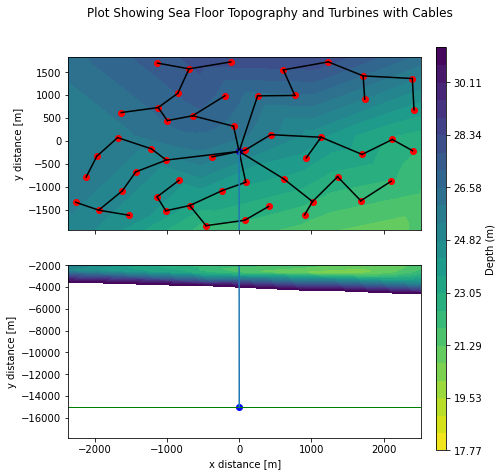

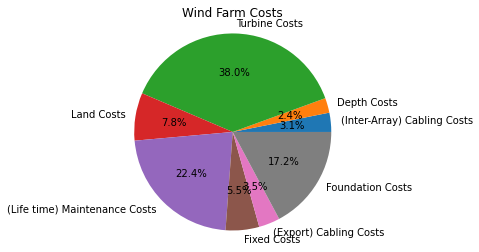

In [65]:
#DISPLAYS OPTIMAL LAYOUT (shows 33 and base)

print('\033[1m'+'\033[4m'+'POST-OPTIMISED LAYOUT INFORMATION (ATTENUATION TESTING)'+'\033[0m'+'\033[0m')
print()
OptimizedTPO = smallestTotalCost/smallestCostPerWatt
plotting_function(smallestpositionlist,smallestindiceslist,MSTweight,data,OnshoreSubstation,smallestExportDistance)
OptimizedPayBackTime,OptimizedDiscountedPayBackTime,OptimizedNPV,OptimizedProfIndex = Payback(OptimizedTPO,smallestTotalCost,smallestpositionlist)

print('\033[1m'+'Total Power Output:'+'\033[0m', OptimizedTPO, 'W')
print('\033[1m'+'Theoretical Max Total Power Output:'+'\033[0m', theoretical_max_power, 'W')
print('\033[1m'+'Percentage power lost to wake effcts:'+'\033[0m', (1-(OptimizedTPO/theoretical_max_power))*100, '%')
print('\033[1m'+'Cost per Watt'+'\033[0m',smallestCostPerWatt,'£/W')
print('')
print('\033[1m'+'Payback Time:'+'\033[0m',OptimizedPayBackTime,'years')
print('\033[1m'+'Discounted Payback Time:'+'\033[0m',OptimizedDiscountedPayBackTime,'years')
print('\033[1m'+'NPV: £'+'\033[0m',OptimizedNPV,'over a ',LifeTimeTurbineOperatingTime,'year period')
print('\033[1m'+'Profitability Index: £'+'\033[0m',OptimizedProfIndex,'over a ',LifeTimeTurbineOperatingTime,'year period')

In [66]:
## SAVE VARIABLE TO FILE FOR USE IN GAUSSIAN CODE
import pickle

optimised_farm_variables = {'smallestpositionlist': smallestpositionlist, 'smallestindiceslist': smallestindiceslist, 'OptimizedTPO': OptimizedTPO, 'smallestTotalCost': smallestTotalCost, 'smallestCostPerWatt': smallestCostPerWatt, 'smallestExportDistance': smallestExportDistance, 'MSTWeightSum':MSTWeightSum}
with open('optimised_farm_variables.pkl', 'wb') as f:
    pickle.dump(optimised_farm_variables, f)

In [67]:
# 8 turbines produce 6MW of output, which is 37.5% of their max output, which is roughly correct.
# If the wind speed decreases by half, power production decreases by a factor of eight.
# On average, therefore, wind turbines do not generate near their capacity.
# Industry estimates project an annual output of 30-40%, but real-world experience shows that
# annual outputs of 15-30% of capacity are more typical in a year. Therefore this improved 37.5% is good.

In [68]:
print(res.success) # whether the minization was succesful or not
print(res.status) # termination status
print(res.message) # Description of the cause of termination
print(res.nit) # number of iterations performed by the optimizer

True
0
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
11
